# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import feather
from scipy.stats import spearmanr

pd.options.display.max_rows = 100

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    # source: https://stackoverflow.com/a/44923103/6931113
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
from arvato_model.utils import *
from arvato_model.plot import *
from arvato_model.stats import *

USE_CACHE = True

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Load data
Read data as string first. Convert dtype on a need to basis.

In [4]:
# load in the data - force all data type to str
n_read_lines = 10000

azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', 
                     sep=';', 
                     na_values={'CAMEO_DEUG_2015': ['X', 'XX'],
                                'CAMEO_DEU_2015': ['X', 'XX'],
                                'CAMEO_INTL_2015': ['X', 'XX']
                               },
                     index_col='LNR',
                     # nrows=n_read_lines, 
                    )

customer = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', 
                        sep=';', 
                        na_values={'CAMEO_DEUG_2015': ['X', 'XX'],
                                   'CAMEO_DEU_2015': ['X', 'XX'],
                                   'CAMEO_INTL_2015': ['X', 'XX']
                               },
                       index_col='LNR',
                       # nrows=n_read_lines, 
                       )

In [5]:
azdias.shape, customer.shape

((891221, 365), (191652, 368))

In [6]:
# No common people between data sets, based on LNR
set(azdias.index).intersection(customer.index)

set()

In [7]:
customer.PRODUCT_GROUP.value_counts() , customer.CUSTOMER_GROUP.value_counts(), customer.ONLINE_PURCHASE.value_counts()

(COSMETIC_AND_FOOD    100860
 FOOD                  47382
 COSMETIC              43410
 Name: PRODUCT_GROUP, dtype: int64, MULTI_BUYER     132238
 SINGLE_BUYER     59414
 Name: CUSTOMER_GROUP, dtype: int64, 0    174356
 1     17296
 Name: ONLINE_PURCHASE, dtype: int64)

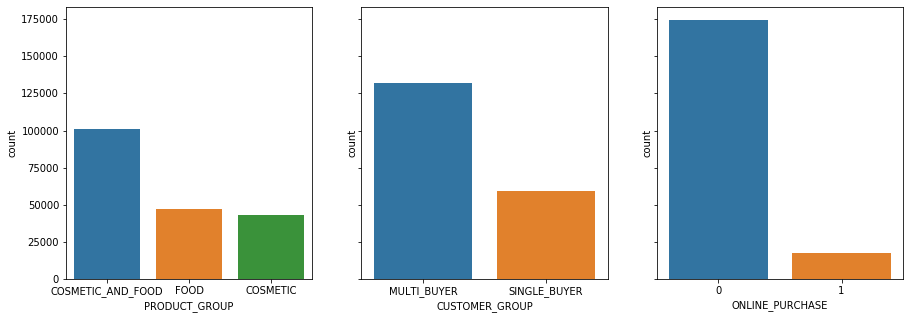

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.countplot(customer.PRODUCT_GROUP, ax=ax[0])
sns.countplot(customer.CUSTOMER_GROUP, ax=ax[1])
sns.countplot(customer.ONLINE_PURCHASE, ax=ax[2])

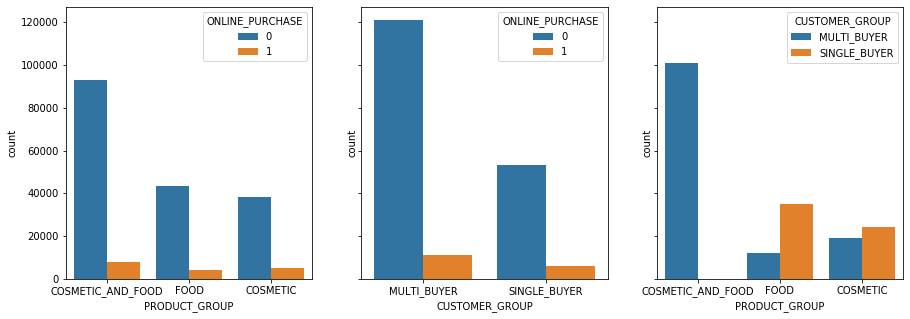

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.countplot(data=customer.loc[:, ['PRODUCT_GROUP', 'ONLINE_PURCHASE']], x='PRODUCT_GROUP', hue='ONLINE_PURCHASE', ax=ax[0])
sns.countplot(data=customer.loc[:, ['CUSTOMER_GROUP', 'ONLINE_PURCHASE']], x='CUSTOMER_GROUP', hue='ONLINE_PURCHASE', ax=ax[1])
sns.countplot(data=customer.loc[:, ['PRODUCT_GROUP', 'CUSTOMER_GROUP']], x='PRODUCT_GROUP', hue='CUSTOMER_GROUP', ax=ax[2])

## Data Type Conversion
1. `EINGEFUEGT_AM` is Date time YYYY-MM-DD HH:MM:SS
1. `OST_WEST_KZ` Can be re-endoded as 0, 1
1. Drop `EINGEFUEGT_AM`
1. In `GEBURTSJAHR` set 0 to na.

Worth looking at : `ANZ_PERSONEN` - number of adults in the household. How to clean this?  it ranges from 0 to 45!

This is supposed to be ranging from 1-3?

In [10]:
# OST_WEST_KZ  (-1, O, W)
azdias.replace({'OST_WEST_KZ': {'O': 0, 'W': 1}}, inplace=True)
customer.replace({'OST_WEST_KZ': {'O': 0, 'W': 1}}, inplace=True)

In [11]:
# drop LNR since it is just an indexing number and the other just a insert timestamp
azdias.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
customer.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [12]:
# cant be born in year 0?
azdias.replace({'GEBURTSJAHR': 0}, pd.np.nan, inplace=True)
customer.replace({'GEBURTSJAHR': 0}, pd.np.nan, inplace=True)

In [13]:
# Worth looking at : ANZ_PERSONEN - number of adults in the household. How to clean this?  it ranges from 0 to 45!
# This is supposed to be ranging from 1-3?
# azdias.loc[:, 'ANZ_PERSONEN'].value_counts()
# customer.loc[:, 'ANZ_PERSONEN'].value_counts()

In [14]:
# Azdias and customers have the same columns
print(set(azdias.columns)-set(customer.columns))
print(set(customer.columns)-set(azdias.columns))

set()
{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}


In [15]:
# Align the columns
customer = customer.loc[:, azdias.columns]

In [16]:
azdias.dtypes.to_csv('data/cache/azdias_dtypes.csv')
customer.dtypes.to_csv('data/cache/customer_dtypes.csv')

C:\Users\Pay1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
C:\Users\Pay1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


## Get meta data
Meta data does not have description for all the columns. Here we try to see which columns have been left out.

Similarly all meta data is not relevant for our data.

In [17]:
meta_data = read_value_meta_data()

Understand which columns have not been covered by meta_data

In [18]:
# Common
with_meta_cols = set(meta_data.Attribute).intersection(set(azdias.columns))
print(len(with_meta_cols))

276


In [19]:
# Not described in meta_data
no_meta_cols = set(azdias.columns) - set(meta_data.Attribute)
print('%s of the cols in data dont have meta data.' % len(no_meta_cols))

88 of the cols in data dont have meta data.


In [20]:
# DROP THE NO META DATA COLUMNS
azdias.drop(no_meta_cols, axis=1, inplace=True)
customer.drop(no_meta_cols, axis=1, inplace=True)

In [21]:
# meta data attributes not in data
meta_attr_not_in_data = set(meta_data.Attribute) - set(azdias.columns)
print('%s attributes in meta data are not in data.' %len(meta_attr_not_in_data))

46 attributes in meta data are not in data.


In [22]:
# CHECKPOINT!!
azdias.reset_index().to_feather('data/cache/azdias_cleaned.feather')
customer.reset_index().to_feather('data/cache/customer_cleaned.feather')

In [23]:
if USE_CACHE:
    azdias = feather.read_dataframe('data/cache/azdias_cleaned.feather')
    azdias.set_index('LNR', inplace=True)
    customer = feather.read_dataframe('data/cache/customer_cleaned.feather')
    customer.set_index('LNR', inplace=True)

C:\Users\Pay1\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


## NA calues count

In [24]:
if USE_CACHE:
    col_na_summary_az = feather.read_dataframe('data/cache/col_na_summary_az.feather')
    col_na_summary_az.set_index('index', inplace=True)
    
    col_na_summary_cu = feather.read_dataframe('data/cache/col_na_summary_cu.feather')
    col_na_summary_cu.set_index('index', inplace=True)
else:
    col_na_summary_az = get_na_summary(azdias)
    col_na_summary_cu = get_na_summary(customer)
    
    col_na_summary_az.reset_index().to_feather('data/cache/col_na_summary_az.feather')
    col_na_summary_cu.reset_index().to_feather('data/cache/col_na_summary_cu.feather')
    

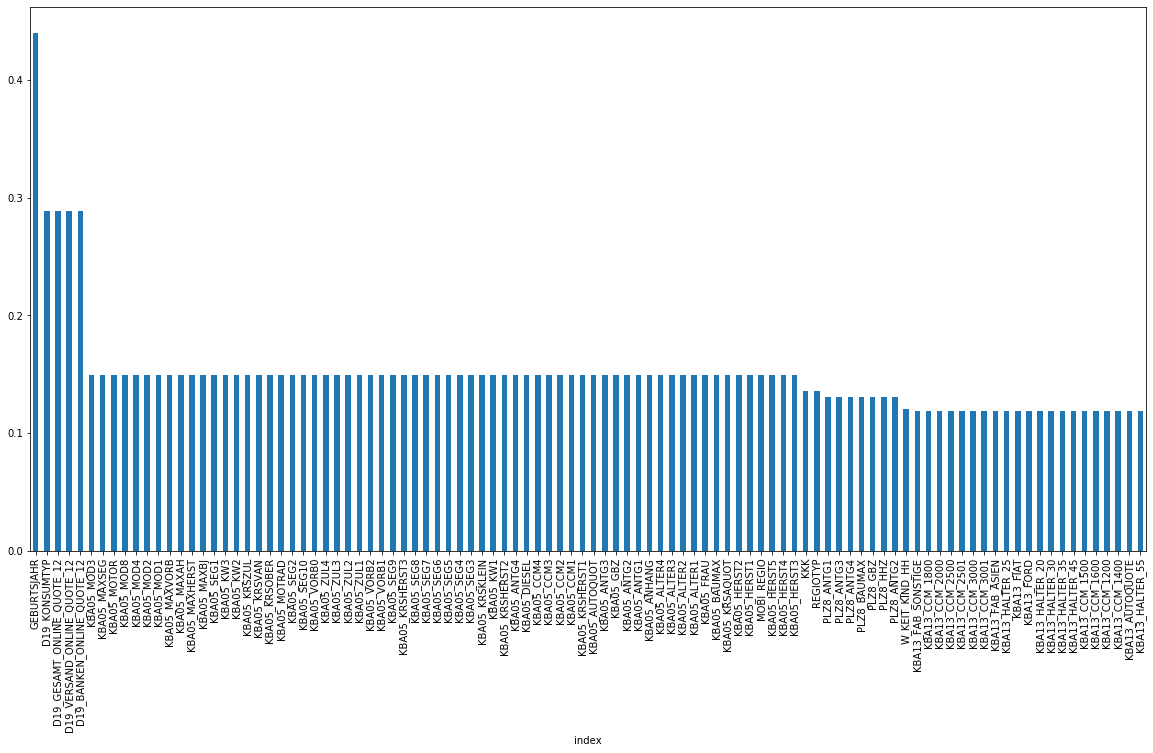

In [25]:
col_na_summary_az.loc[:, 'na_perc'].head(100).plot.bar(figsize=(20, 10));

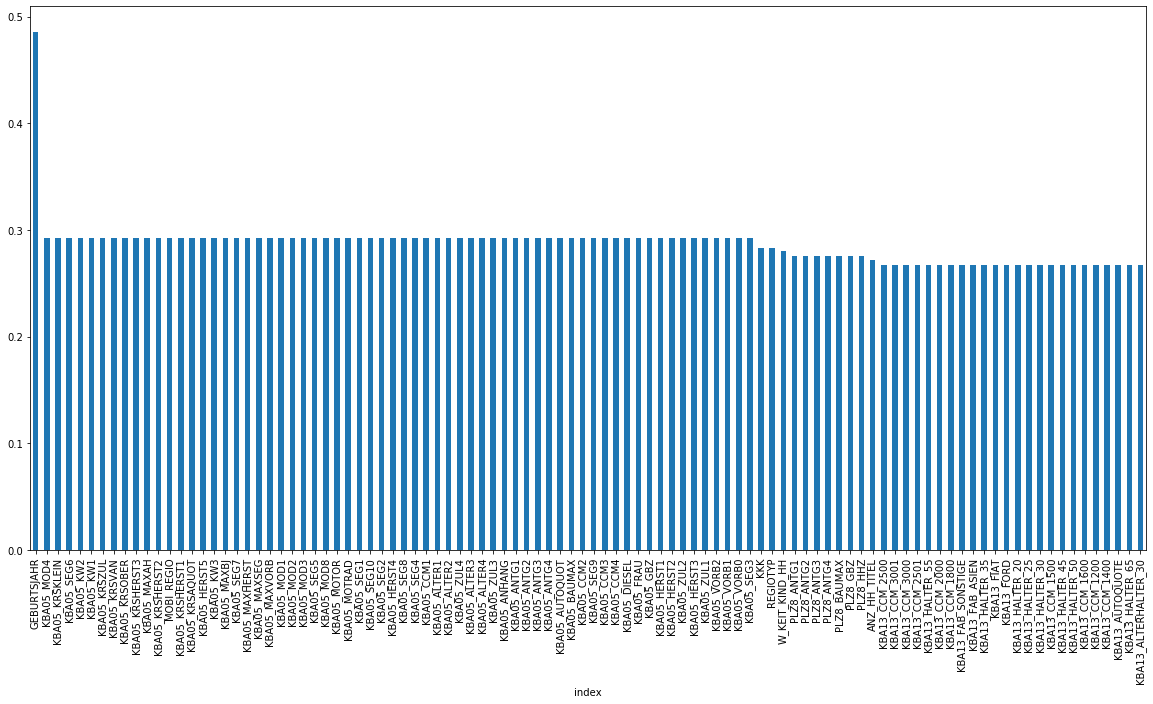

In [26]:
col_na_summary_cu.loc[:, 'na_perc'].head(100).plot.bar(figsize=(20, 10));

In [27]:
if USE_CACHE:
    row_na_summary_az = feather.read_dataframe('data/cache/row_na_summary_az.feather')
    row_na_summary_az.set_index('LNR', inplace=True)
    
    row_na_summary_cu = feather.read_dataframe('data/cache/row_na_summary_cu.feather')
    row_na_summary_cu.set_index('LNR', inplace=True)
else:
    row_na_summary_az = get_na_summary(azdias, axis=1)
    row_na_summary_cu = get_na_summary(customer, axis=1)
    
    row_na_summary_az.reset_index().to_feather('data/cache/row_na_summary_az.feather')
    row_na_summary_cu.reset_index().to_feather('data/cache/row_na_summary_cu.feather')

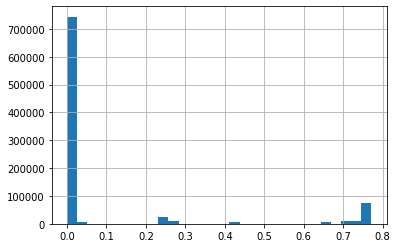

In [28]:
row_na_summary_az.loc[:, 'na_perc'].hist(bins=30);

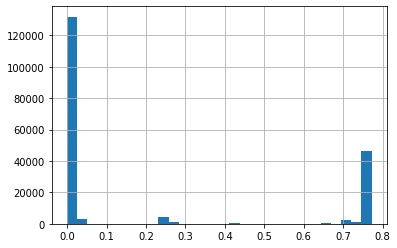

In [29]:
row_na_summary_cu.loc[:, 'na_perc'].hist(bins=30);

## Missing values count

In [30]:
na_dict = get_values_missing(meta_data, sep=', ')

# if we need to convert this to string, int, float
na_dict = {key: [float(i) for i in val] for key, val in na_dict.items()}

In [31]:
# Replace the missing values as NA
# .replace is painfully slow - so use the Series.map(dictionary.get) - https://stackoverflow.com/a/41987136/6931113
if USE_CACHE:
    azdias = feather.read_dataframe('data/cache/azdias_cleaned_na_rpl.feather')
    azdias.set_index('LNR', inplace=True)
    customer = feather.read_dataframe('data/cache/customer_cleaned_na_rpl.feather')
    customer.set_index('LNR', inplace=True)
else:    
    azdias.replace(na_dict, pd.np.nan, inplace=True)
    customer.replace(na_dict, pd.np.nan, inplace=True)
    
    azdias.reset_index().to_feather('data/cache/azdias_cleaned_na_rpl.feather')
    customer.reset_index().to_feather('data/cache/customer_cleaned_na_rpl.feather')

In [32]:
if USE_CACHE:
    col_na_summary_az = feather.read_dataframe('data/cache/col_na_summary_az_na_rpl.feather')
    col_na_summary_az.set_index('index', inplace=True)
    
    col_na_summary_cu = feather.read_dataframe('data/cache/col_na_summary_cu_na_rpl.feather')
    col_na_summary_cu.set_index('index', inplace=True)
    
else:    
    # Review how the NA distribution has changed in col and rows
    col_na_summary_az = get_na_summary(azdias)
    col_na_summary_cu = get_na_summary(customer)
    col_na_summary_az.reset_index().to_feather('data/cache/col_na_summary_az_na_rpl.feather')
    col_na_summary_cu.reset_index().to_feather('data/cache/col_na_summary_cu_na_rpl.feather')

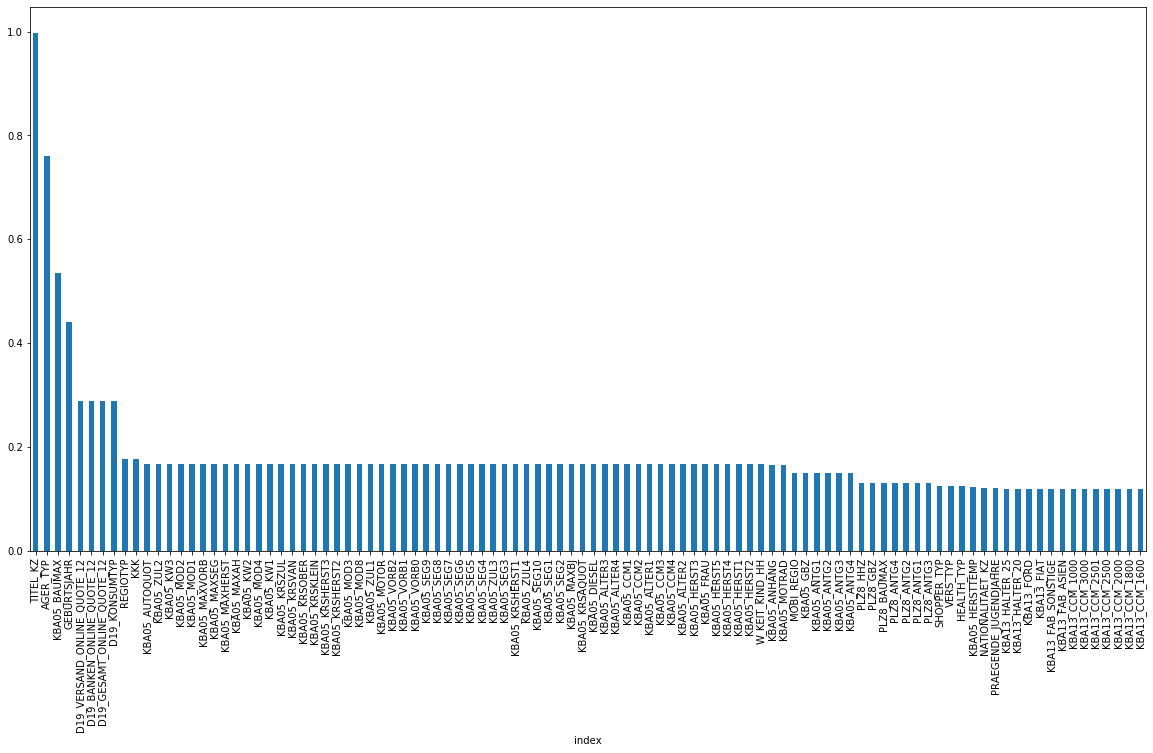

In [33]:
col_na_summary_az.loc[:, 'na_perc'].head(100).plot.bar(figsize=(20, 10));

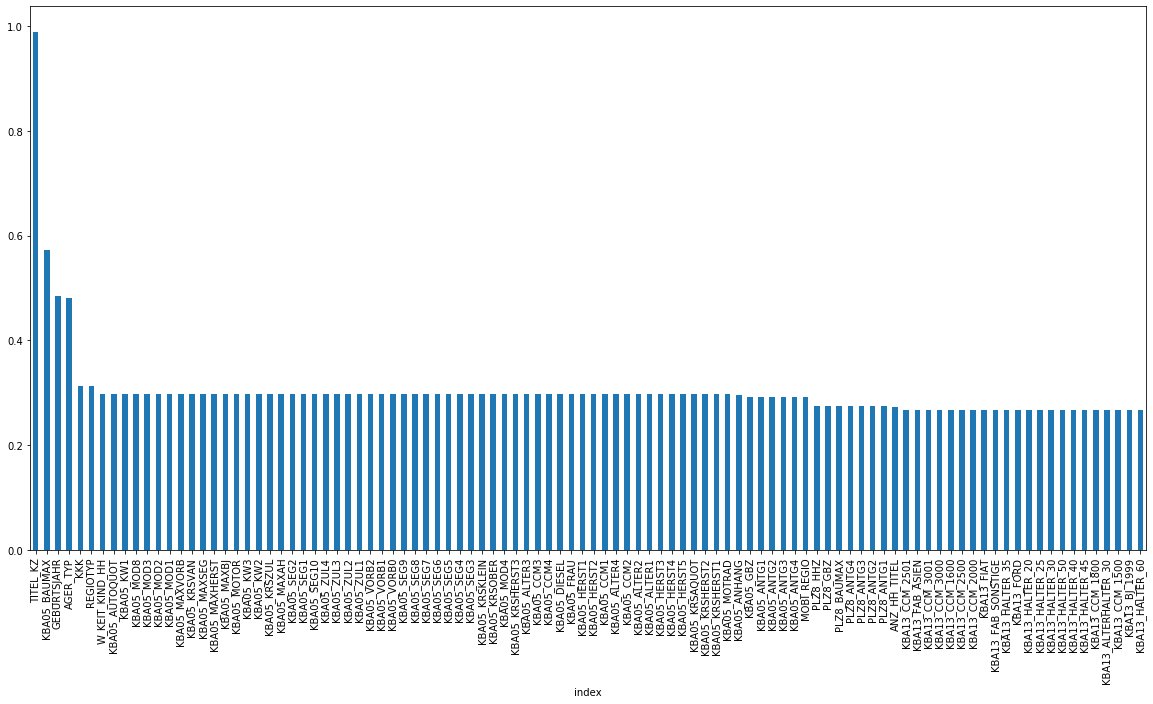

In [34]:
col_na_summary_cu.loc[:, 'na_perc'].head(100).plot.bar(figsize=(20, 10));

In [35]:
if USE_CACHE:
    row_na_summary_az = feather.read_dataframe('data/cache/row_na_summary_az_na_rpl.feather')
    row_na_summary_az.set_index('LNR', inplace=True)
    
    row_na_summary_cu = feather.read_dataframe('data/cache/row_na_summary_cu_na_rpl.feather')
    row_na_summary_cu.set_index('LNR', inplace=True)
else:
    row_na_summary_az = get_na_summary(azdias, axis=1)
    row_na_summary_cu = get_na_summary(customer, axis=1)
    row_na_summary_az.reset_index().to_feather('data/cache/row_na_summary_az_na_rpl.feather')
    row_na_summary_cu.reset_index().to_feather('data/cache/row_na_summary_cu_na_rpl.feather')

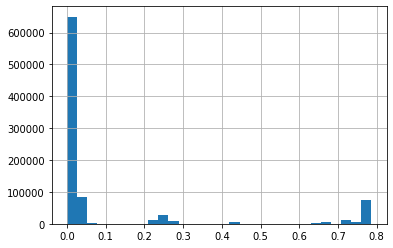

In [36]:
row_na_summary_az.loc[:, 'na_perc'].hist(bins=30)

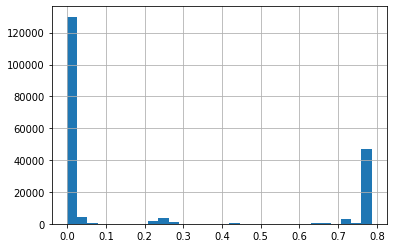

In [37]:
row_na_summary_cu.loc[:, 'na_perc'].hist(bins=30)

In [38]:
if USE_CACHE:
    azdias = feather.read_dataframe('data/cache/azdias_cleaned_na_rpl_drop.feather')
    azdias.set_index('LNR', inplace=True)
    customer = feather.read_dataframe('data/cache/customer_cleaned_na_rpl_drop.feather')
    customer.set_index('LNR', inplace=True)
else:
    high_na_cols = ['TITEL_KZ', 'KBA05_BAUMAX', 'AGER_TYP', 'GEBURTSJAHR']
    azdias.drop(high_na_cols, axis=1, inplace=True)
    customer.drop(high_na_cols, axis=1, inplace=True)
    azdias.reset_index().to_feather('data/cache/azdias_cleaned_na_rpl_drop.feather')
    customer.reset_index().to_feather('data/cache/customer_cleaned_na_rpl_drop.feather')

##  Drop duplicates after NA treatment?

No - We do not drop duplicates - since they are still responses from individual people

## Check uniqueness and distribution

Here we only sample the first 10,000 rows to get an idea.

In [43]:
if USE_CACHE:
    diversity_index_az = feather.read_dataframe('data/cache/diversity_index_az.feather')
    diversity_index_az.set_index('index', inplace=True)
else:
    col_uq = azdias.iloc[0:10000, :].nunique()
    # Calculate the Simpsons and Shannon diversity index and get the Equivalence
    shannon_idx = azdias.iloc[0:10000, :].apply(shannon_diversity_index)
    shannon_idx = shannon_idx/np.log(col_uq)
    diversity_index_az = pd.DataFrame({'shannon': shannon_idx})
    diversity_index_az.reset_index().to_feather('data/cache/diversity_index_az.feather')

In [44]:
if USE_CACHE:
    diversity_index_cu = feather.read_dataframe('data/cache/diversity_index_cu.feather')
    diversity_index_cu.set_index('index', inplace=True)
else:

    col_uq = customer.iloc[0:10000, :].nunique()
    # Calculate the Simpsons and Shannon diversity index and get the Equivalence
    shannon_idx = customer.iloc[0:10000, :].apply(shannon_diversity_index)
    shannon_idx = shannon_idx/np.log(col_uq)
    diversity_index_cu = pd.DataFrame({'shannon': shannon_idx})
    diversity_index_cu.reset_index().to_feather('data/cache/diversity_index_cu.feather')

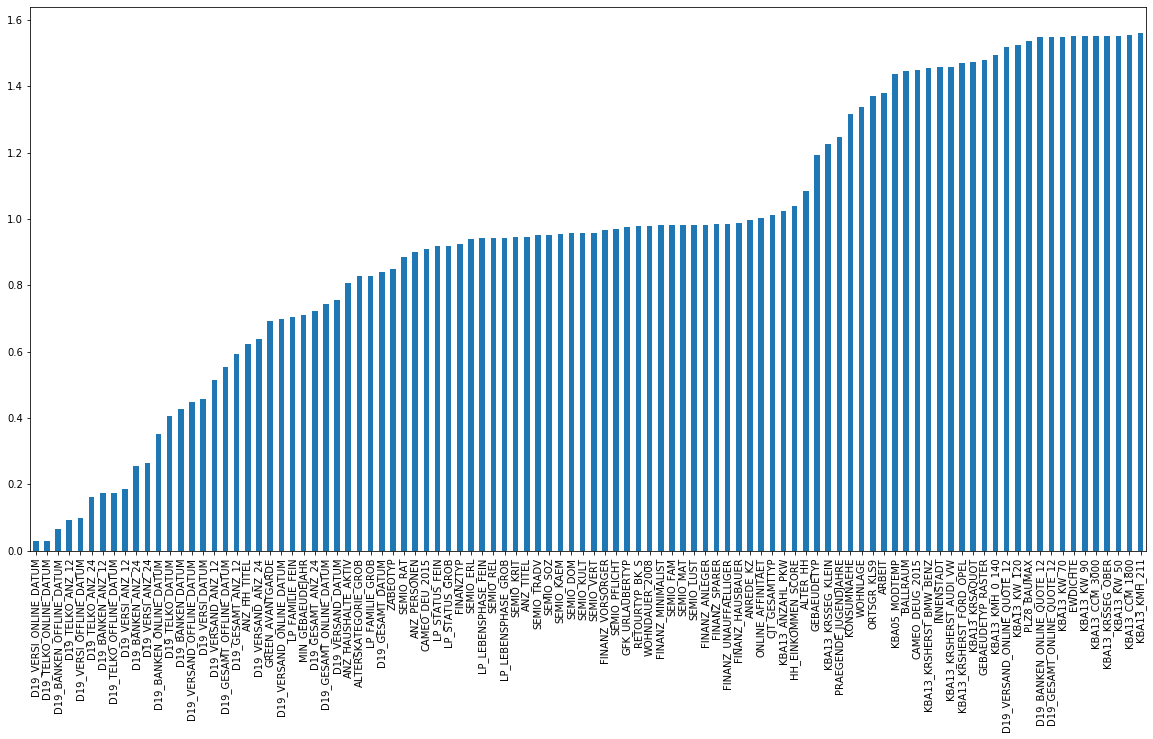

In [45]:
diversity_index_az.loc[:, 'shannon'].sort_values(ascending=True).head(100).plot.bar(figsize=(20, 10));

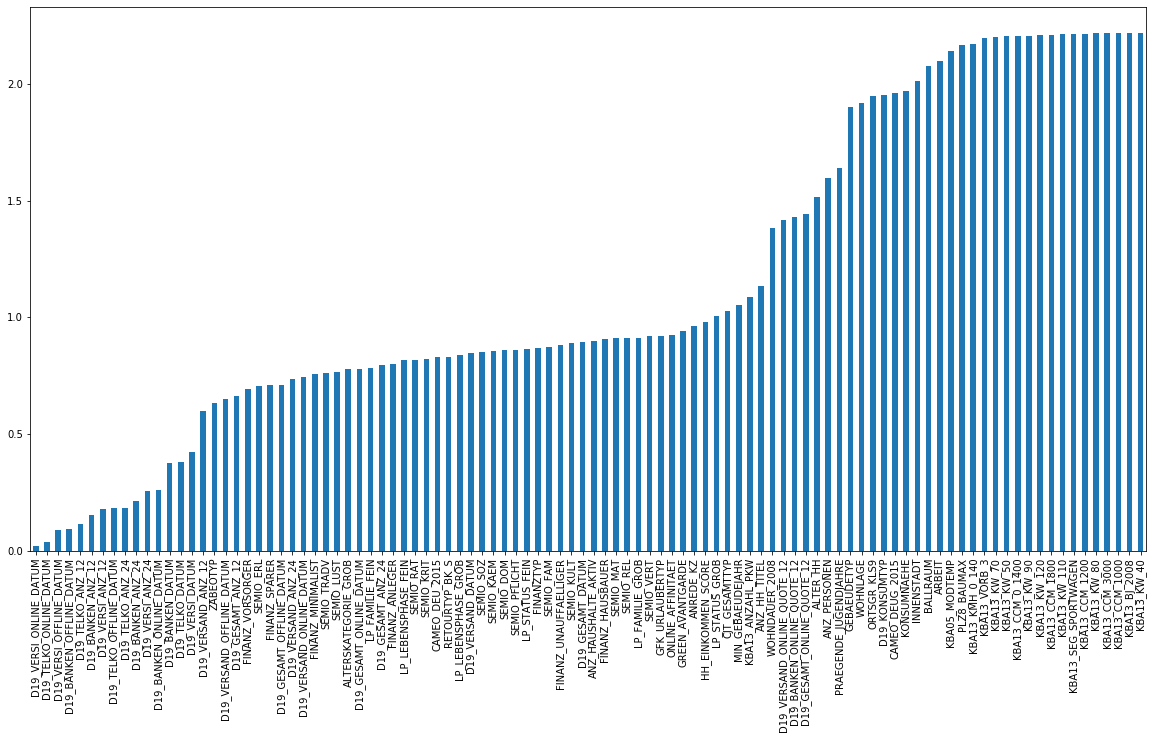

In [46]:
diversity_index_cu.loc[:, 'shannon'].sort_values(ascending=True).head(100).plot.bar(figsize=(20, 10));

In [47]:
# Here we plot the value distribution by each col.
EQUIVALENCE_THRESHOLD = 0.5
low_div_col = diversity_index_az.loc[diversity_index_az.shannon<=EQUIVALENCE_THRESHOLD, :].index
idx = [list(azdias.columns).index(c) for c in low_div_col]
print('{} col have less than {} equivalence'.format(len(idx), EQUIVALENCE_THRESHOLD))

16 col have less than 0.5 equivalence


In [48]:
plot_dim = int(np.ceil(np.sqrt(len(idx))))

C:\Users\Pay1\Documents\Github\arvato_customer_segmentation\arvato_model\plot.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


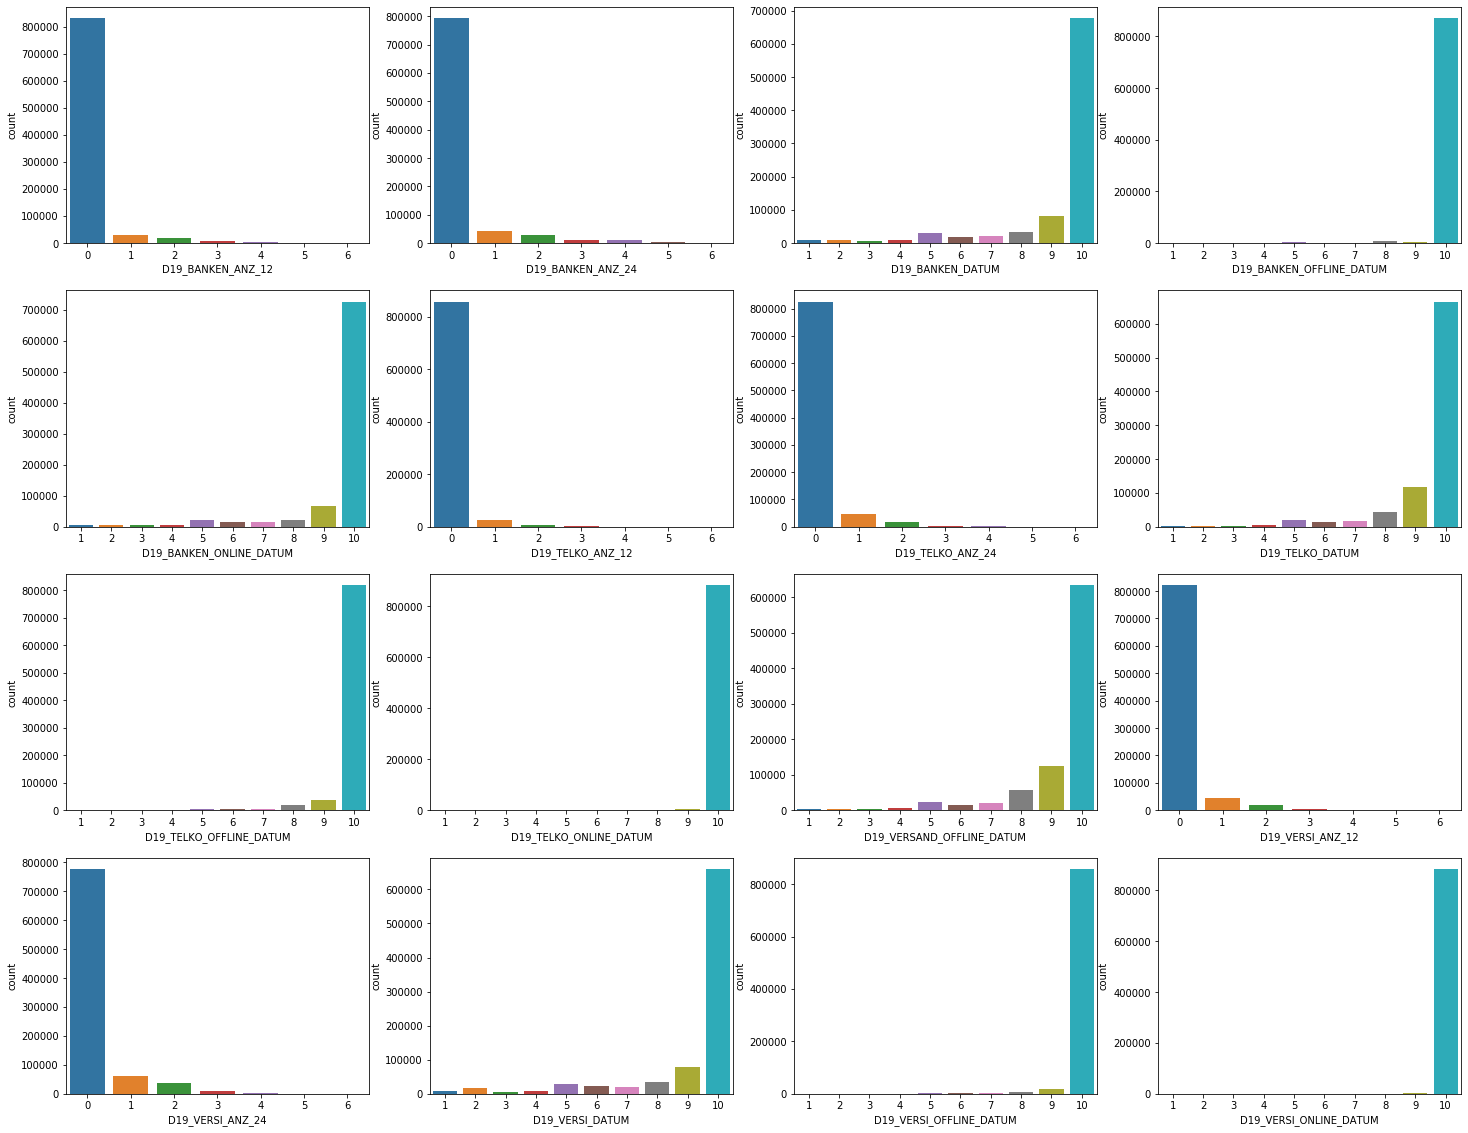

In [49]:
plot_data_dist(azdias, col_idx=idx, n_col=plot_dim, n_row=plot_dim)

# See correlation

A quick view of how the data is correlated. Highlight any pair that has abs corr higher than 0.5

In [51]:
if USE_CACHE:
    rank_corr_az = feather.read_dataframe('data/cache/rank_corr_az.feather')
    rank_corr_az.set_index('index', inplace=True)
    
    rank_corr_cu = feather.read_dataframe('data/cache/rank_corr_cu.feather')
    rank_corr_cu.set_index('index', inplace=True)
else:
    idx = ~azdias.columns.isin(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'])
    
    rho_az, pval_az = spearmanr(azdias.iloc[:, idx].dropna(how='any').values)
    rho_cu, pval_cu = spearmanr(customer.iloc[:, idx].dropna(how='any').values)
    
    rank_corr_az = pd.DataFrame(rho_az, columns = azdias.iloc[:, idx].columns, index=azdias.iloc[:, idx].columns)
    rank_corr_cu = pd.DataFrame(rho_cu, columns = customer.iloc[:, idx].columns, index=customer.iloc[:, idx].columns)
    
    rank_corr_az.reset_index().to_feather('data/cache/rank_corr_az.feather')
    rank_corr_cu.reset_index().to_feather('data/cache/rank_corr_cu.feather')

In [52]:
# Set corr of less than 0.5 to 0 for the purpose of plotting.
CORR_THRESHOLD = 0.5

rank_corr_az_abs = rank_corr_az.abs()
rank_corr_az_abs.where(rank_corr_az_abs > CORR_THRESHOLD, 0, inplace=True)

rank_corr_cu_abs = rank_corr_cu.abs()
rank_corr_cu_abs.where(rank_corr_cu_abs > CORR_THRESHOLD, 0, inplace=True)

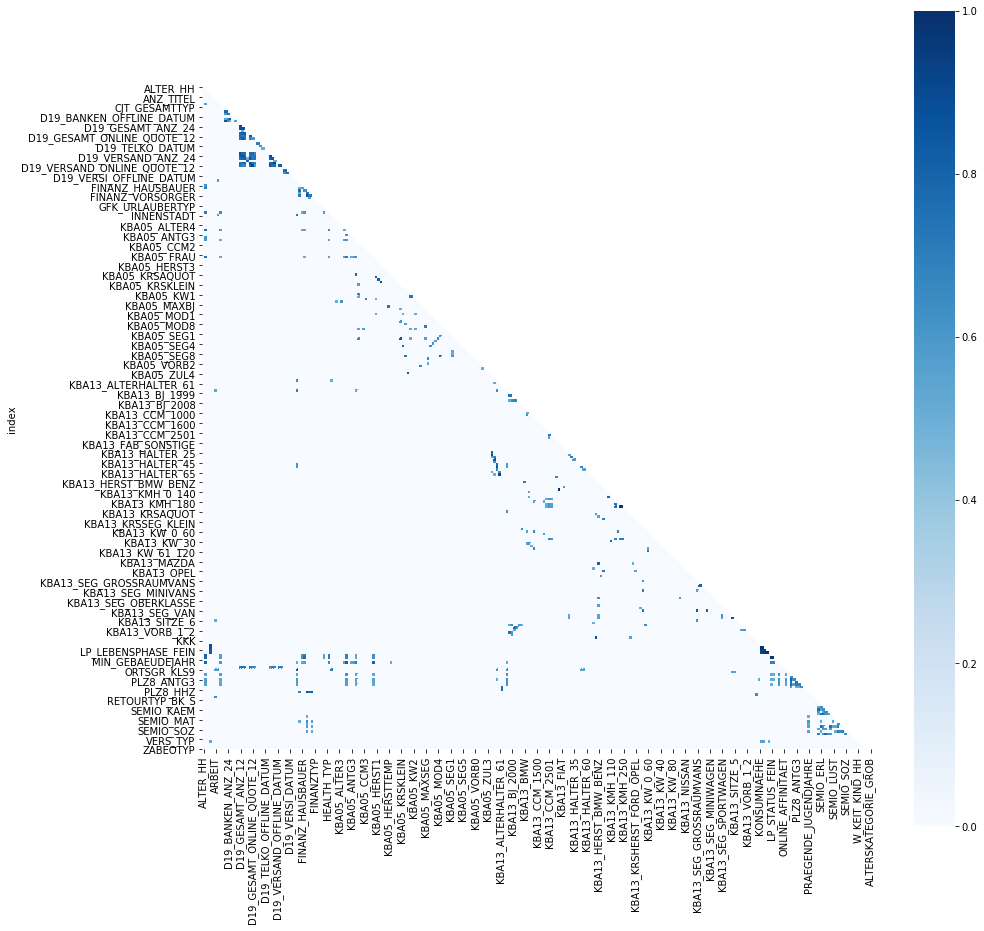

In [53]:
# Plot only those whose corr exceeds the threshold
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
plt.figure(figsize=(15, 15))
mask = np.zeros_like(rank_corr_az_abs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rank_corr_az_abs, cmap='Blues', square=True, mask=mask);

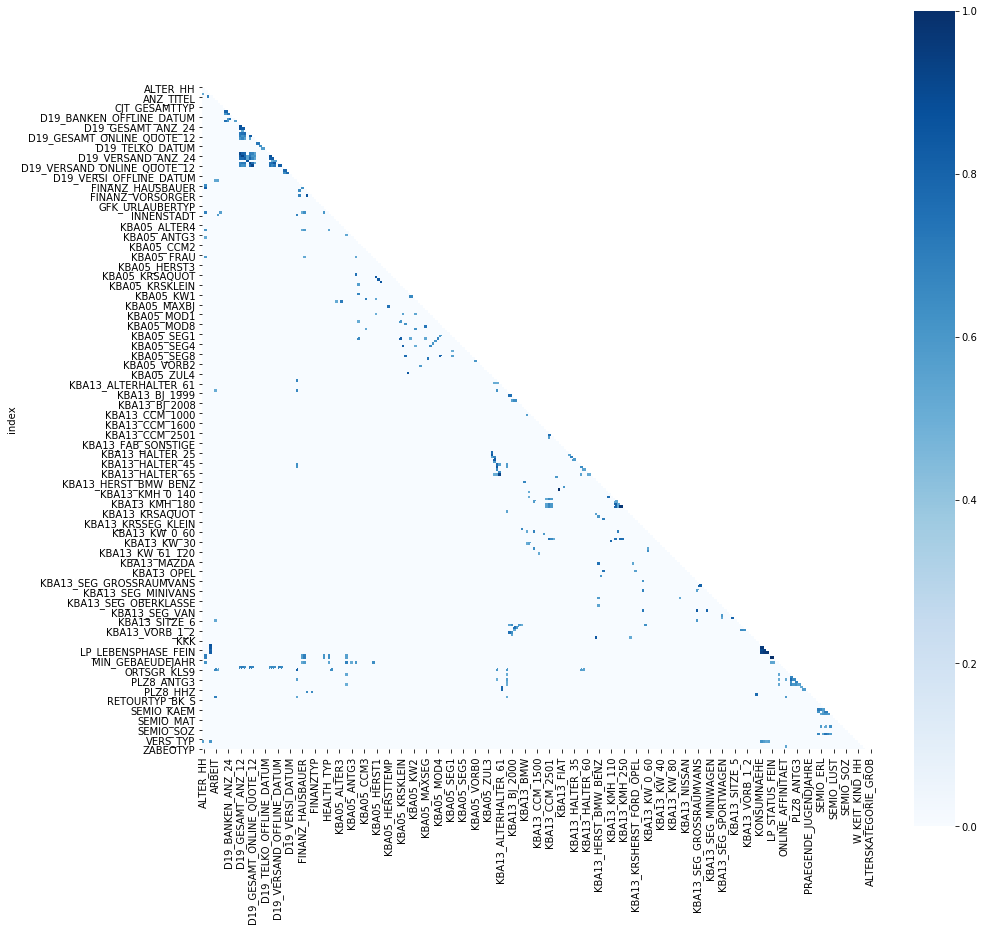

In [54]:
# Plot only those whose corr exceeds the threshold
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
plt.figure(figsize=(15, 15))
mask = np.zeros_like(rank_corr_cu_abs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rank_corr_cu_abs, cmap='Blues', square=True, mask=mask);

# Compare distribution by Information Level

We want to see what sets them apart. So for eacH information level - plot the distributions side by side.
Do a chi square test as well.

As per meta data
1. PERSON - 43
1. Household - 32
1. Building - 10
1. Microcell (RR4_ID) - 3
1. Microcell (RR3_ID) - 64 - focuses mainly on cars and vehicle ownership
1. 125m x 125m Grid - 33 Transactional activity 
1. Postcode - 4
1. RR1_ID - 5
1. PLZ8 - 114 Car owner ship data
1. Community - 5


In [39]:
def get_attributes(info_level, meta_data=meta_data):
    idx = meta_data.loc[:, 'Information level']==info_level
    attributes = meta_data.loc[idx, 'Attribute'].unique()
    
    return attributes

In [40]:
all_diff_attributes = {}

## Person

In [41]:
info_level = 'Person'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [42]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

In [43]:
len(similar_attributes), len(different_attributes)

(10, 29)

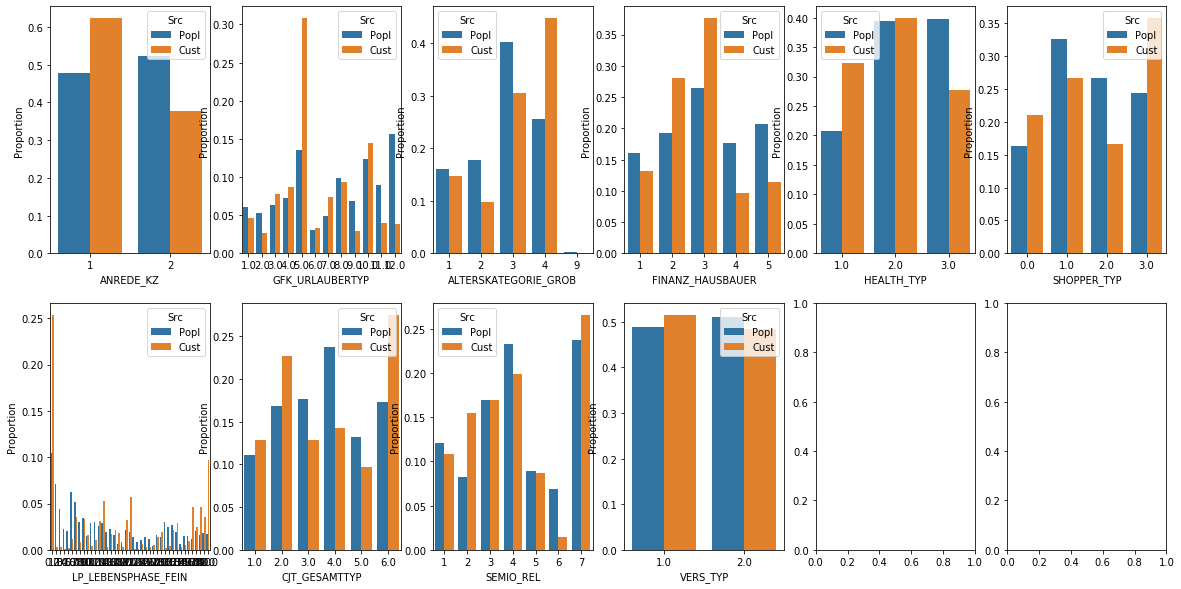

In [44]:
plot_data_dist_comp(azdias, customer, similar_attributes, 6, 2, (20, 10))

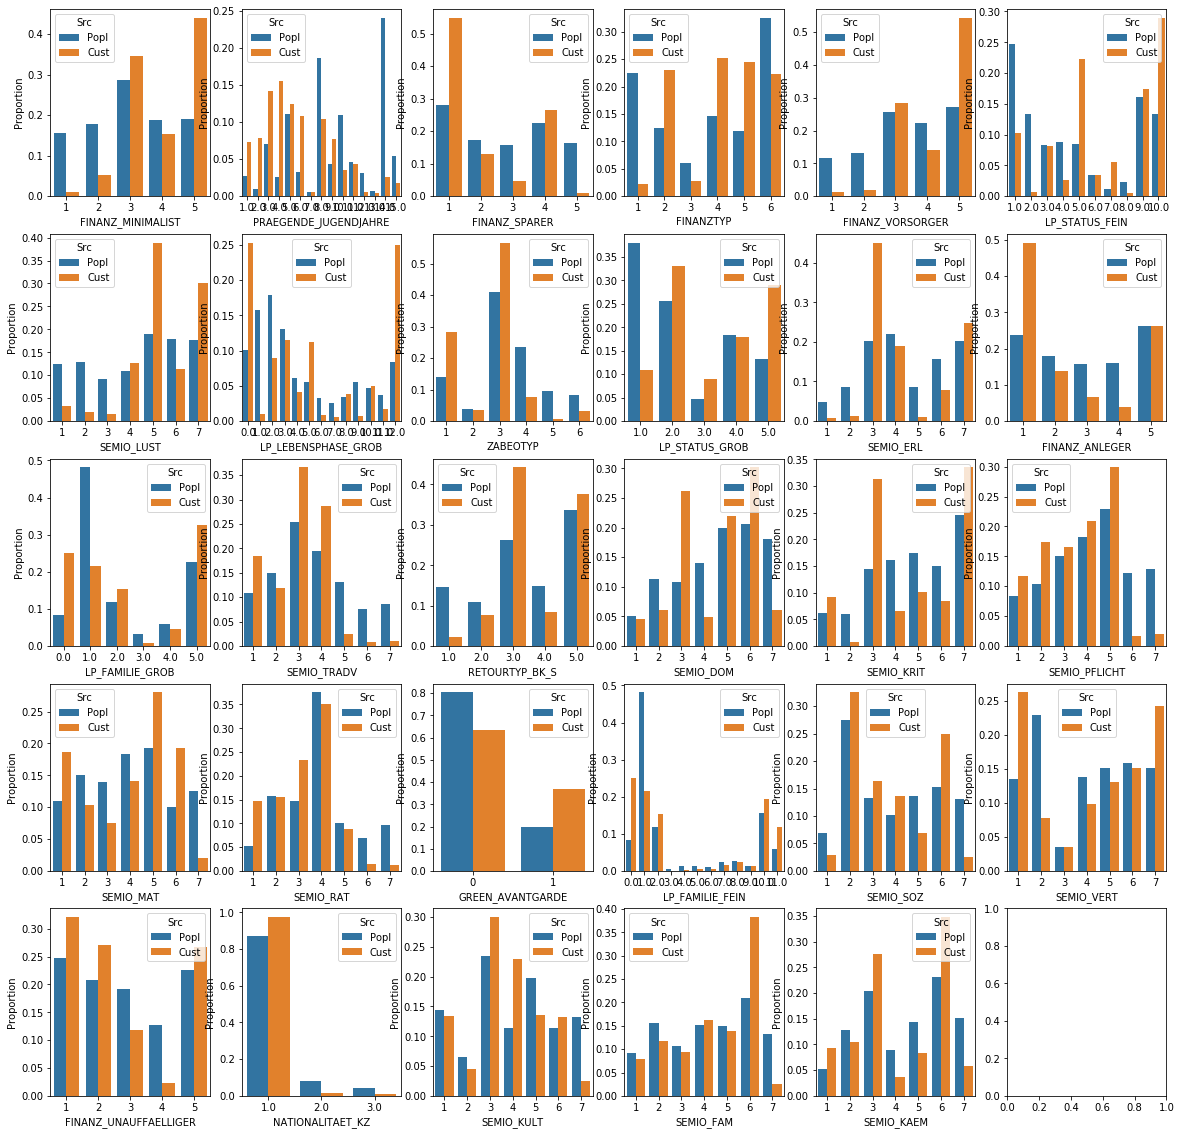

In [45]:
plot_data_dist_comp(azdias, customer, different_attributes, 6, 5, (20, 20))

## Household

In [46]:
info_level = 'Household'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [47]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

C:\Users\Pay1\Anaconda3\lib\site-packages\scipy\stats\contingency.py:244: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):
C:\Users\Pay1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Pay1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Pay1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [48]:
len(similar_attributes), len(different_attributes)

(29, 6)

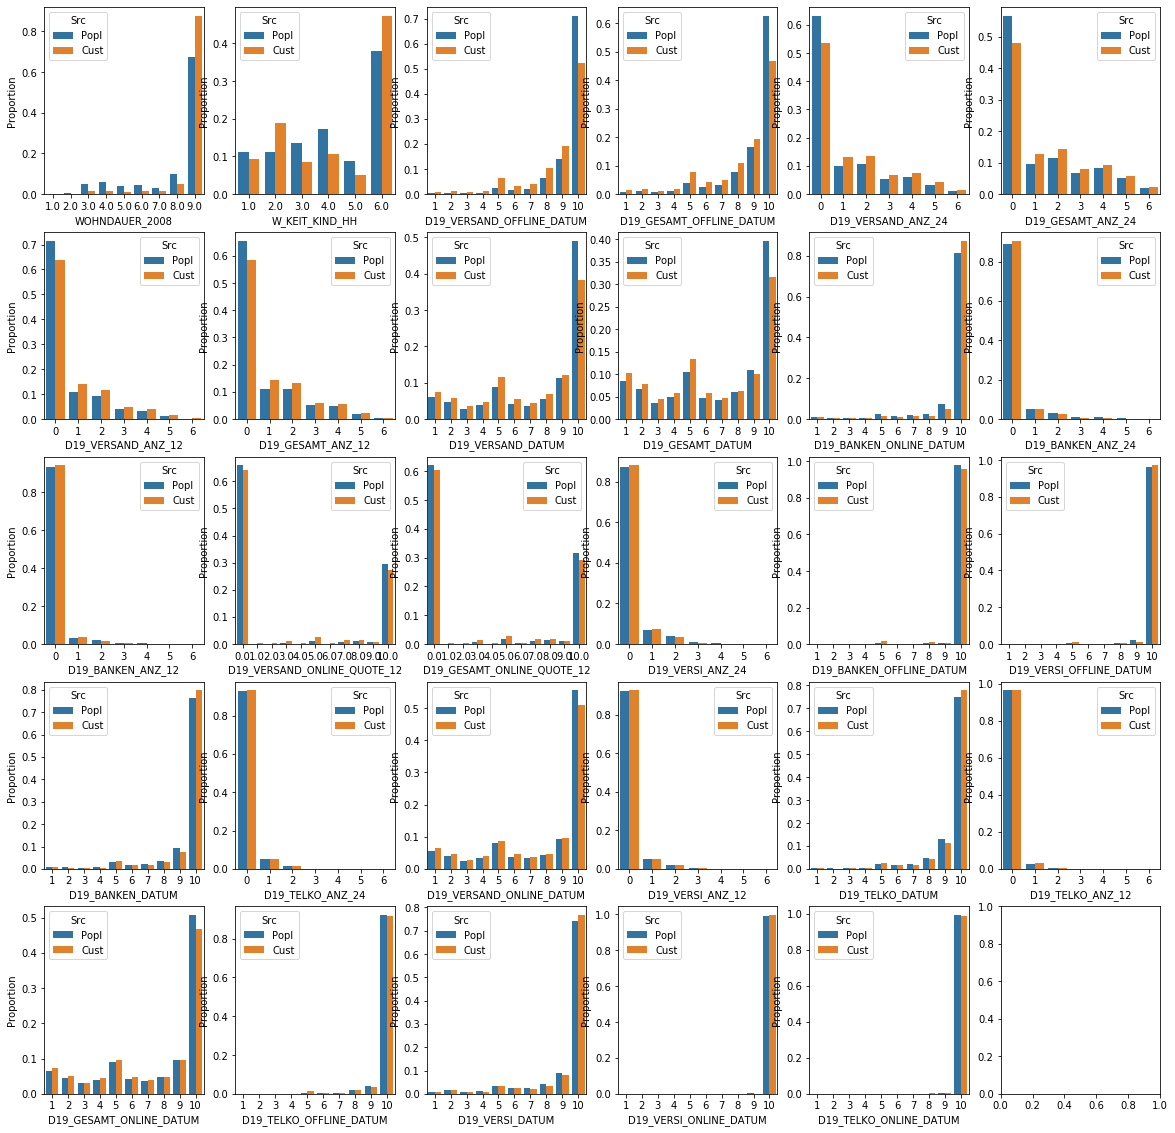

In [49]:
plot_data_dist_comp(azdias, customer, similar_attributes, 6, 5, (20, 20))

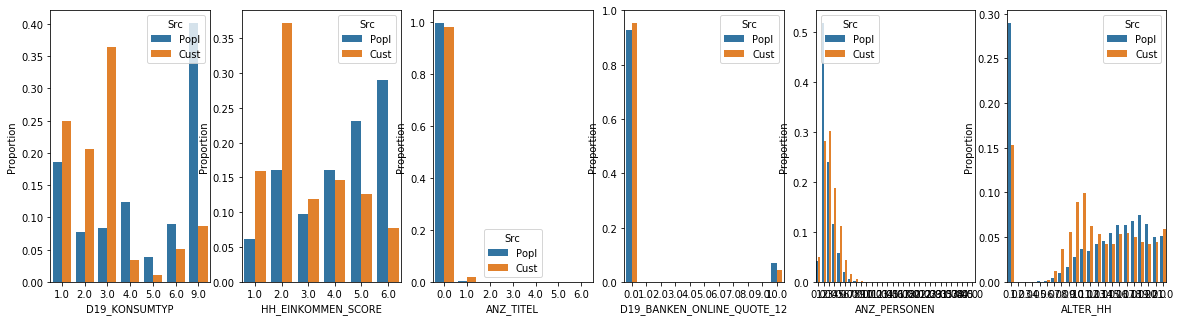

In [50]:
plot_data_dist_comp(azdias, customer, different_attributes, 6, 1, (20, 5))

## Building

In [51]:
info_level = 'Building'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [52]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

In [53]:
len(similar_attributes), len(different_attributes)

(5, 4)

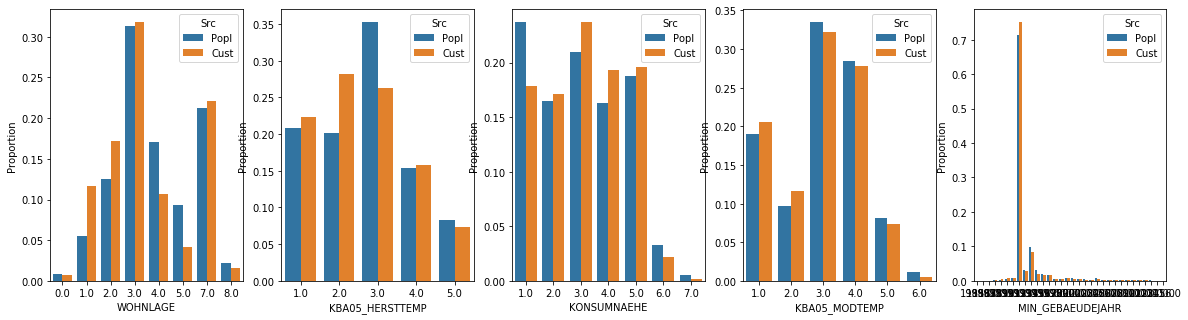

In [54]:
plot_data_dist_comp(azdias, customer, similar_attributes, 5, 1, (20, 5))

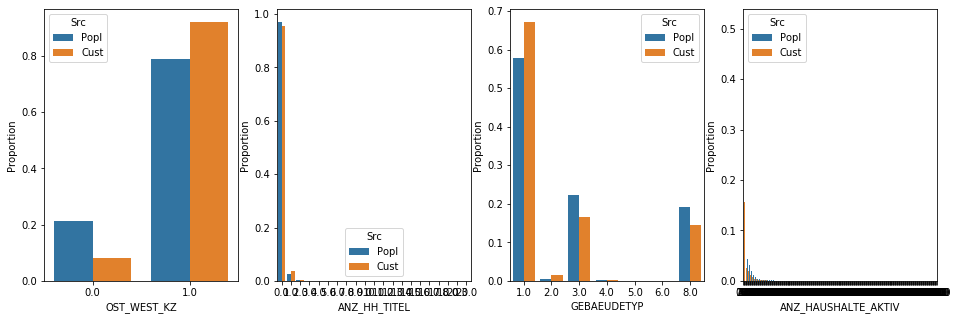

In [55]:
plot_data_dist_comp(azdias, customer, different_attributes, 4, 1, (16, 5))

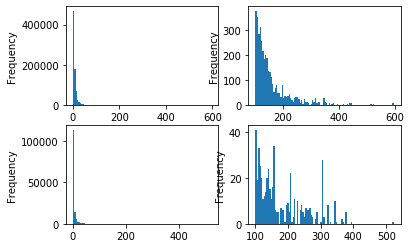

In [56]:
# Number of households in the building.
fig, ax = plt.subplots(2, 2);
azdias.loc[:, 'ANZ_HAUSHALTE_AKTIV'].plot.hist(bins=100, ax=ax[0, 0])
azdias.loc[azdias.ANZ_HAUSHALTE_AKTIV > 100, 'ANZ_HAUSHALTE_AKTIV'].plot.hist(bins=100, ax=ax[0, 1])
customer.loc[:, 'ANZ_HAUSHALTE_AKTIV'].plot.hist(bins=100, ax=ax[1, 0])
customer.loc[customer.ANZ_HAUSHALTE_AKTIV > 100, 'ANZ_HAUSHALTE_AKTIV'].plot.hist(bins=100, ax=ax[1, 1])

## Microcell (RR4_ID)

In [57]:
info_level = 'Microcell (RR4_ID)'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [58]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

In [59]:
len(similar_attributes), len(different_attributes)

(10, 1)

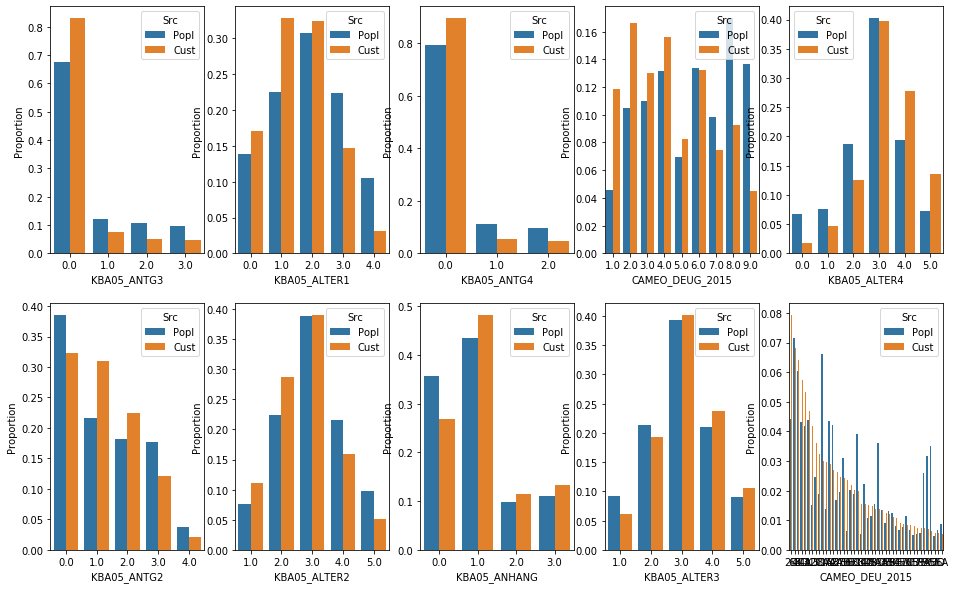

In [60]:
plot_data_dist_comp(azdias, customer, similar_attributes, 5, 2, (16, 10))

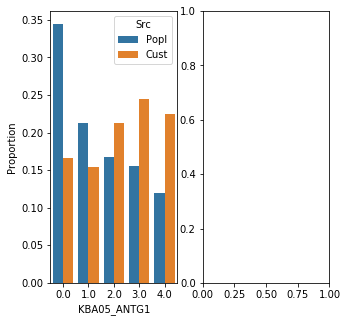

In [61]:
plot_data_dist_comp(azdias, customer, different_attributes, 2, 1, (5, 5))

## Microcell (RR3_ID)

In [62]:
info_level = 'Microcell (RR3_ID)'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [63]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

In [64]:
len(similar_attributes), len(different_attributes)

(52, 1)

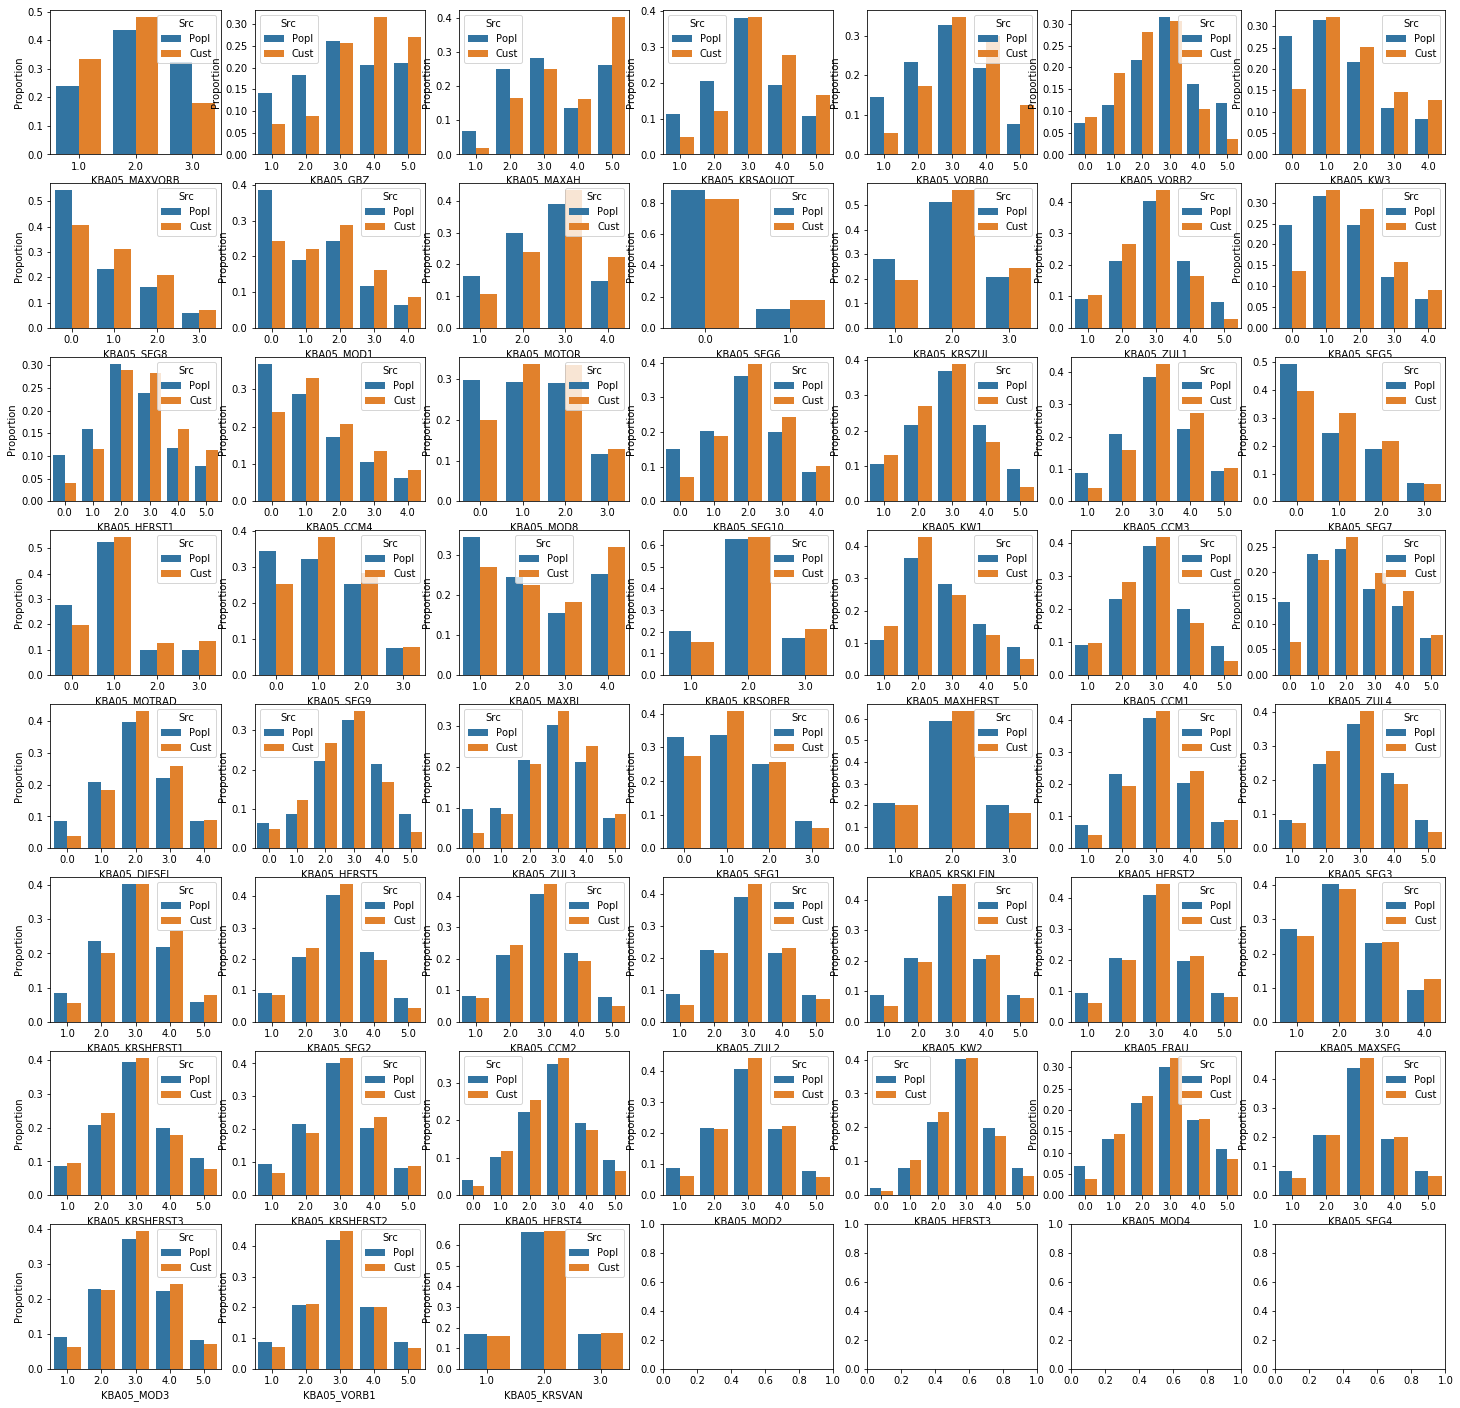

In [65]:
plot_data_dist_comp(azdias, customer, similar_attributes, 7, 8, (25, 25))

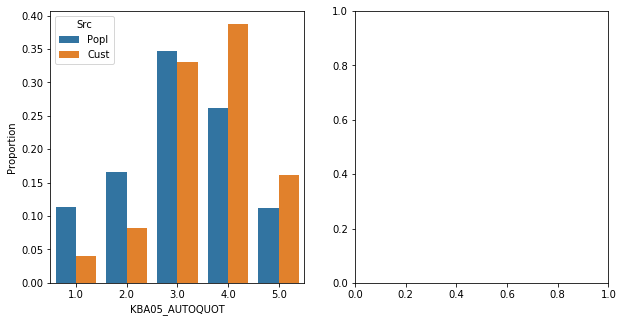

In [66]:
plot_data_dist_comp(azdias, customer, different_attributes, 2, 1, (10, 5))

## 125m x 125m Grid

In [67]:
plot_attributes = get_attributes('125m x 125m Grid')
plot_attributes = list(set(plot_attributes).intersection(customer.columns))
if plot_attributes:
    plot_data_dist_comp(azdias, customer, plot_attributes, 6, 5, (25, 25))
else:
    print('WARNING: The attributes for information level \'125m x 125m Grid\' are not found in data set')

## Postcode

In [68]:
plot_attributes = get_attributes('Postcode')
plot_attributes = list(set(plot_attributes).intersection(customer.columns))
if plot_attributes:
    plot_data_dist_comp(azdias, customer, plot_attributes, 4, 1, (20, 5))
else:
    print('WARNING: The attributes for information level \'Postcode\' are not found in data set')

## RR1_ID

In [69]:
info_level = 'RR1_ID'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [70]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

In [71]:
len(similar_attributes), len(different_attributes)

(3, 2)

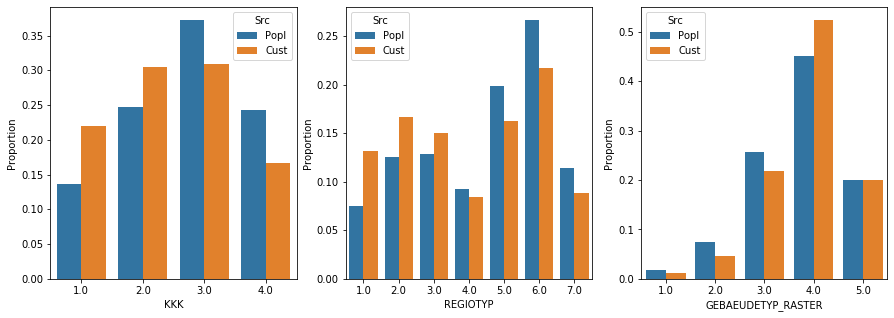

In [72]:
plot_data_dist_comp(azdias, customer, similar_attributes, 3, 1, (15, 5))

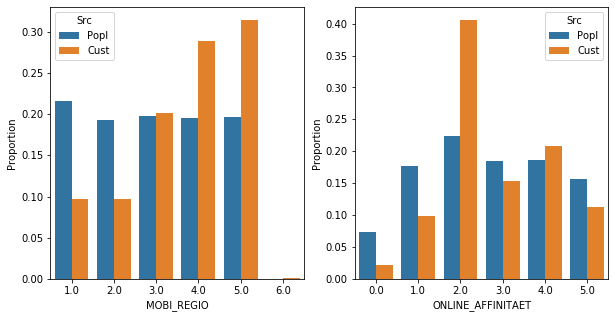

In [73]:
plot_data_dist_comp(azdias, customer, different_attributes, 2, 1, (10, 5))

## PLZ8

In [74]:
info_level = 'PLZ8'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [75]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

In [76]:
len(similar_attributes), len(different_attributes)

(107, 7)

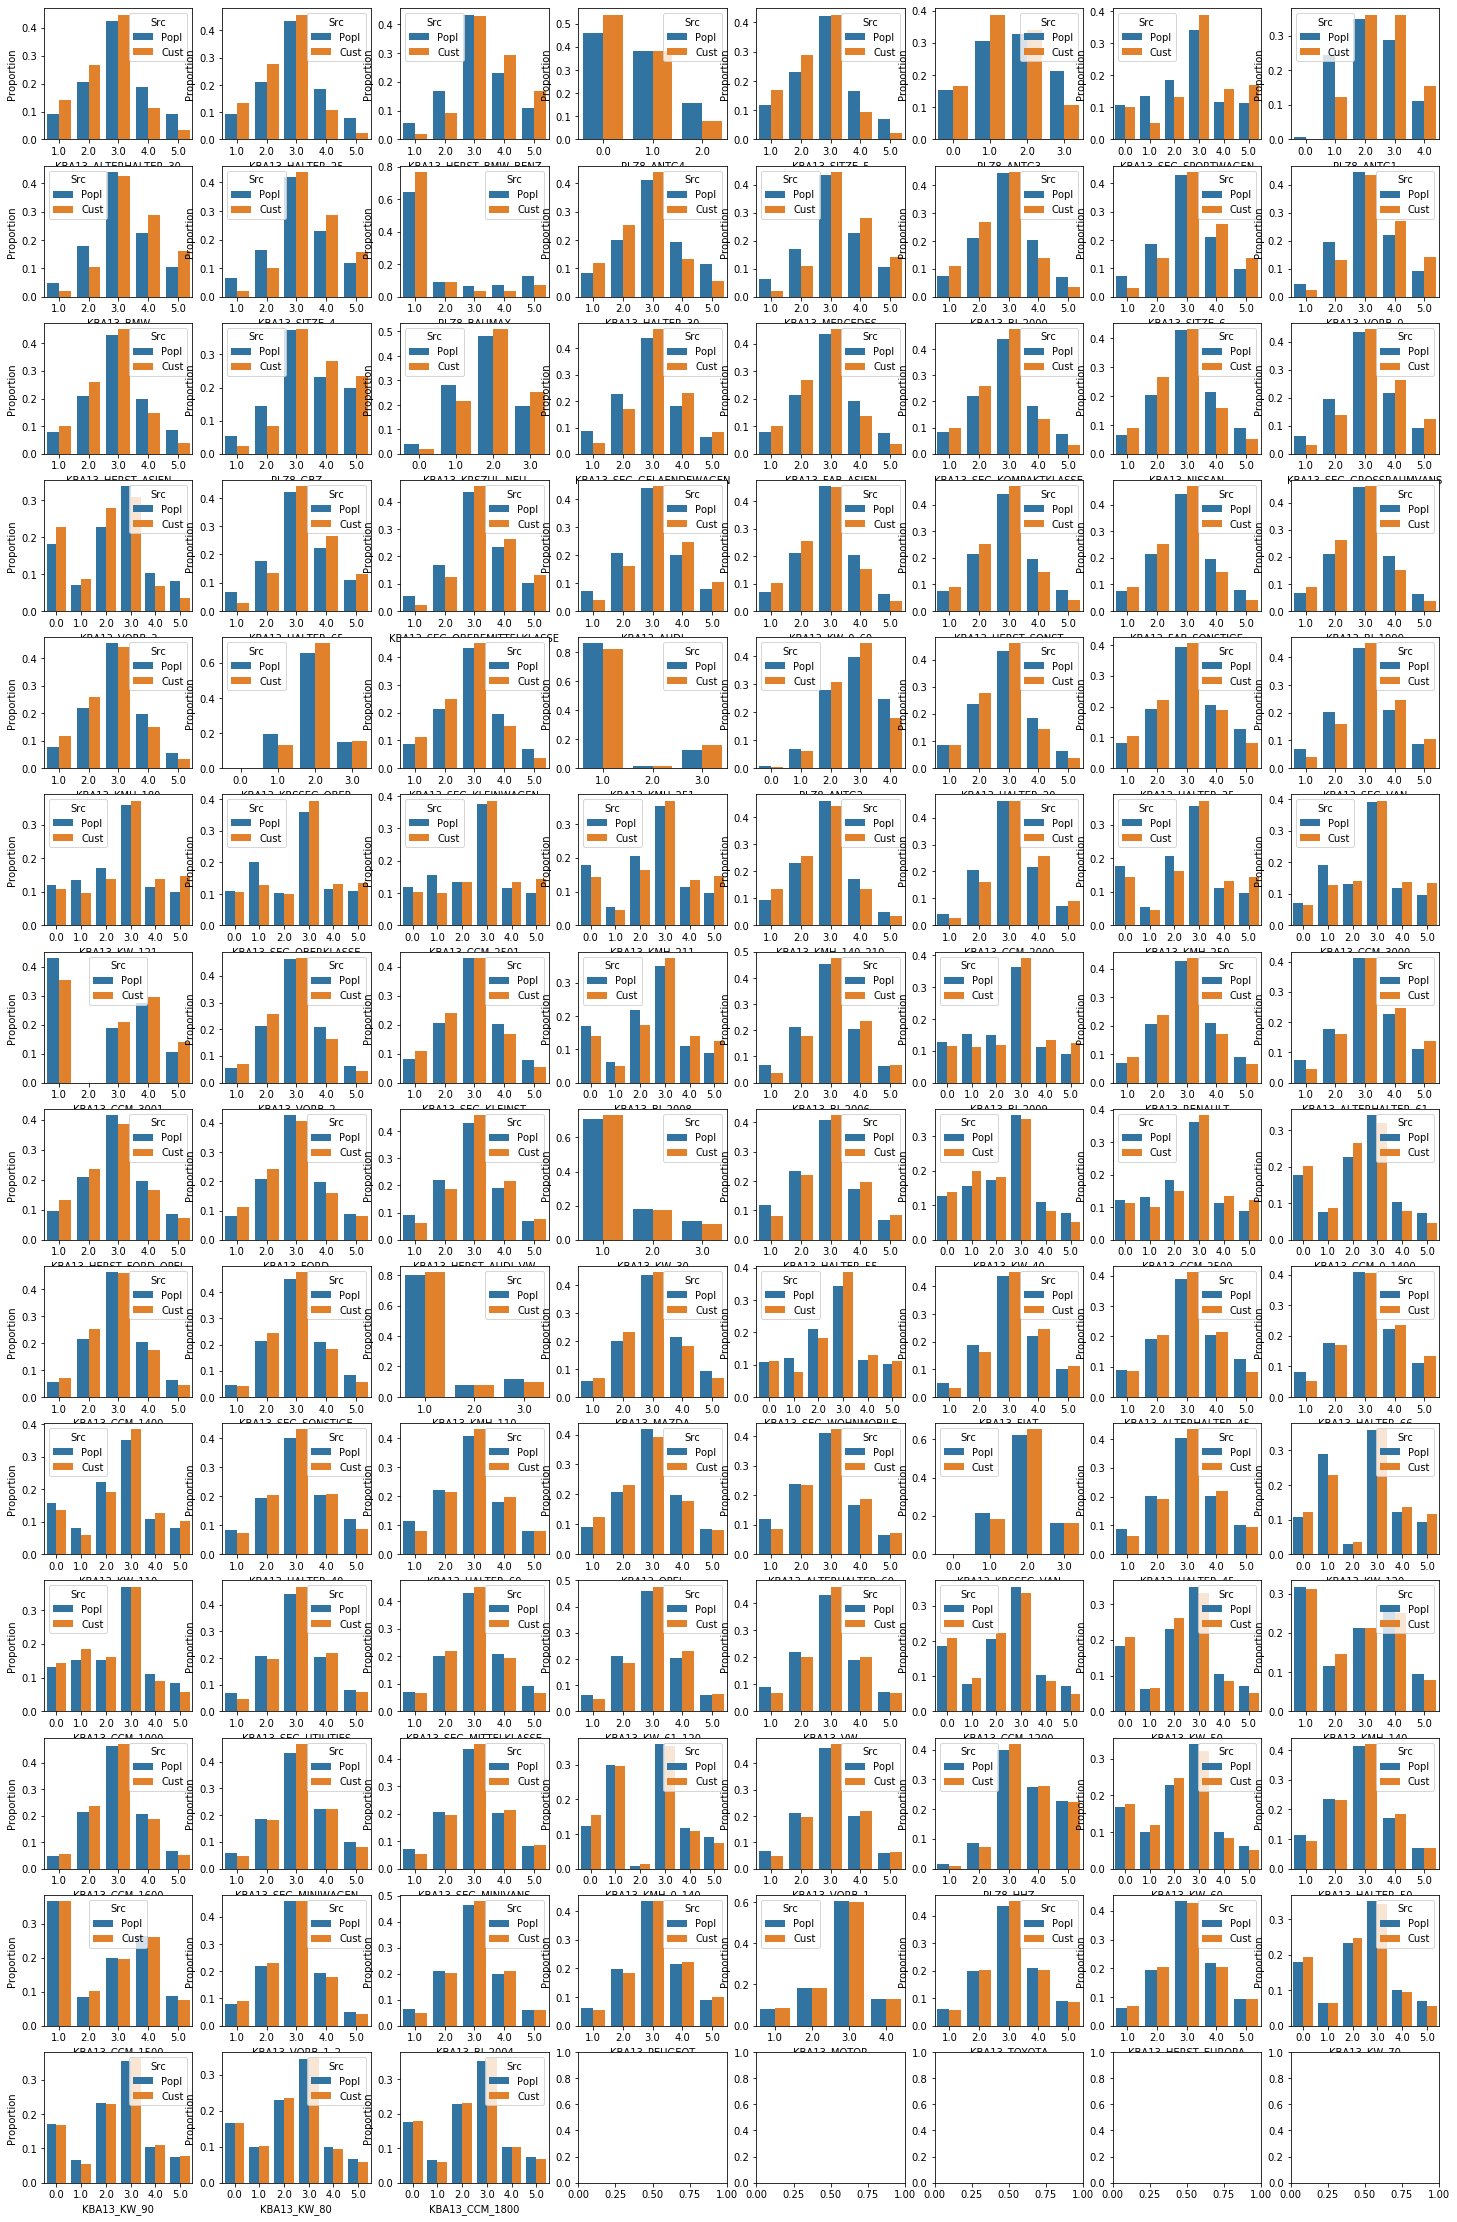

In [77]:
plot_data_dist_comp(azdias, customer, similar_attributes, 8, 14, (25, 40))

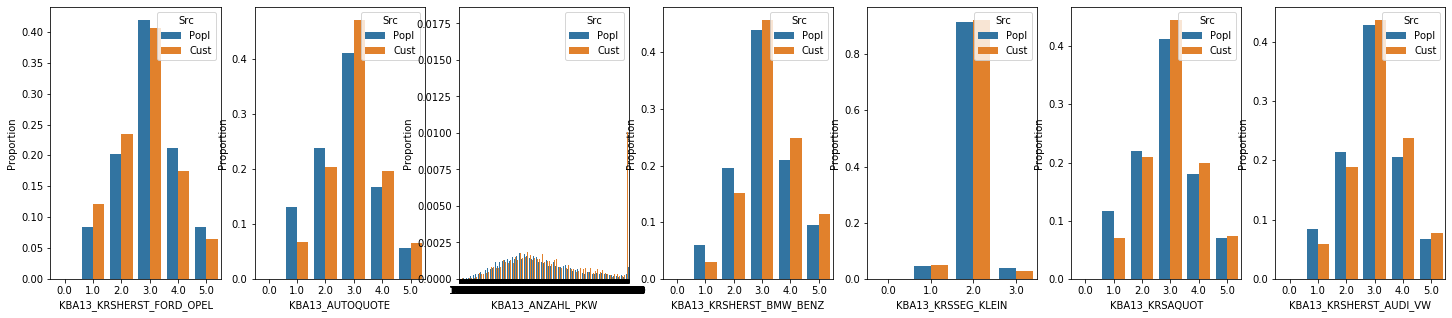

In [78]:
plot_data_dist_comp(azdias, customer, different_attributes, 7, 1, (25, 5))

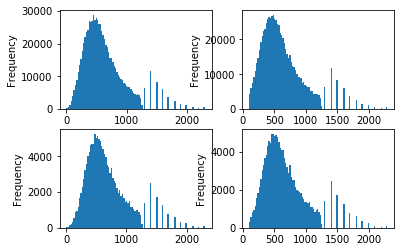

In [79]:
# number of cars in the PLZ8
fig, ax = plt.subplots(2, 2);
azdias.loc[:, 'KBA13_ANZAHL_PKW'].plot.hist(bins=100, ax=ax[0, 0])
azdias.loc[azdias.KBA13_ANZAHL_PKW > 100, 'KBA13_ANZAHL_PKW'].plot.hist(bins=100, ax=ax[0, 1])
customer.loc[:, 'KBA13_ANZAHL_PKW'].plot.hist(bins=100, ax=ax[1, 0])
customer.loc[customer.KBA13_ANZAHL_PKW > 100, 'KBA13_ANZAHL_PKW'].plot.hist(bins=100, ax=ax[1, 1])

## Community

In [80]:
info_level = 'Community'
plot_attributes = get_attributes(info_level)
plot_attributes = list(set(plot_attributes).intersection(customer.columns))

In [81]:
similarity = calc_chi2_stats(azdias, customer, plot_attributes).sort_values('p')
similar_attributes = similarity.loc[similarity.similar, :].index
different_attributes = similarity.loc[~similarity.similar, :].index
all_diff_attributes[info_level] = different_attributes

In [82]:
len(similar_attributes), len(different_attributes)

(2, 1)

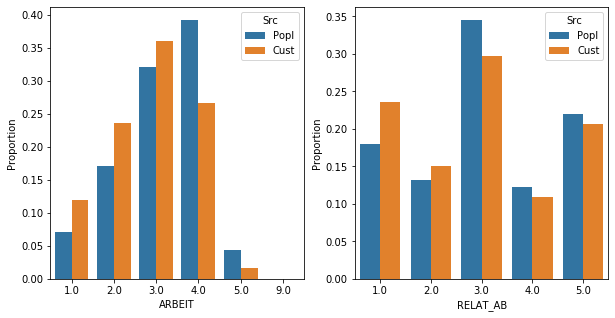

In [83]:
plot_data_dist_comp(azdias, customer, similar_attributes, 2, 1, (10, 5))

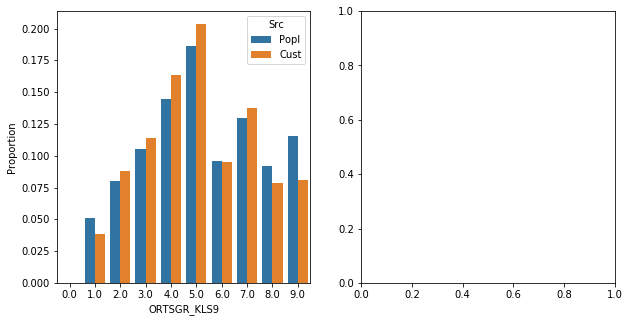

In [84]:
plot_data_dist_comp(azdias, customer, different_attributes, 2, 1, (10, 5))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [122]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import feather
from scipy.stats import spearmanr
from joblib import dump, load
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer


# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    # source: https://stackoverflow.com/a/44923103/6931113
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
from arvato_model.utils import *
from arvato_model.plot import *
from arvato_model.stats import *

USE_CACHE = True

In [4]:
meta_data = read_value_meta_data()

In [6]:
non_categorical = ['ANZ_HAUSHALTE_AKTIV',
                   'ANZ_HH_TITEL',
                   'ANZ_PERSONEN',
                   'ANZ_TITEL',
                   'KBA13_ANZAHL_PKW',
                  ]

USE_MODEL_CACHE = True

In [5]:
if USE_CACHE :
    
    # WE WONT READ THE WHOLE FILE
    # azdias = feather.read_dataframe('data/cache/1_azdias_loaded.feather')
    
    # INSTEAD Load the sample file 
    azdias = feather.read_dataframe('data/cache/1_azdias_loaded_smpl.feather')
    azdias.set_index('LNR', inplace=True)
    
    customer = feather.read_dataframe('data/cache/1_customer_loaded.feather')
    customer.set_index('LNR', inplace=True)
    
    customer_purchase = feather.read_dataframe('data/cache/1_customer_purchase_loaded.feather')
    customer_purchase.set_index('LNR', inplace=True)
    
else:
    start_time = time.perf_counter()
    azdias = read_data('data/Udacity_AZDIAS_052018.csv', meta_data)
    print('Finished reading azdias file in {} min'.format((time.perf_counter()-start_time)/60))

    start_time = time.perf_counter()
    customer = read_data('data/Udacity_CUSTOMERS_052018.csv', meta_data)
    print('Finished reading customer file in {} min'.format((time.perf_counter()-start_time)/60))
    
    # Finished reading azdias file in 0.87 min
    # Finished reading customer file in 0.15 min
    
    no_meta_cols = set(azdias.columns) - set(meta_data.Attribute)
    azdias.drop(no_meta_cols, axis=1, inplace=True)
    customer.drop(no_meta_cols, axis=1, inplace=True)
    
    azdias.reset_index().to_feather('data/cache/1_azdias_loaded.feather')
    customer.reset_index().to_feather('data/cache/1_customer_loaded.feather')
    customer_purchase.reset_index().to_feather('data/cache/1_customer_purchase_loaded.feather')
    
    # WORK ONLY ON A SAMPLE SET
    azdias = azdias.dropna(how='any').sample(n=100000)
    azdias.reset_index().to_feather('data/cache/1_azdias_loaded_smpl.feather')
    

C:\Users\Pay1\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [7]:
# What we would like to do is : which person can be a mail-order customer and which ones cannot = so use the ONLINE_PURCHASE column
mail_order_customers = customer_purchase.loc[customer_purchase.ONLINE_PURCHASE == 0, :].index
online_order_customers = customer_purchase.loc[customer_purchase.ONLINE_PURCHASE == 1, :].index

## PCA and K-Means

We cant do PCA on the **whole** dataset as we dont have enough memory

`MemoryError: Unable to allocate array with shape (1568, 700043) and data type float64`

So we try on complete case *samples* of the population data and try to tease out the similar attributes when compared with customers.

We shall segregate the data into information levels.

The workflow is as follows:

**For each information level**

1. One hot encode the subset data
2. Scale the subset data
3. Find the components to explain ~90% variance
4. Transform data
5. Perform the K-Means Clustering.
1. Find the best number of clusters
1. Train K-Means for N

1. Predict for popl
1. Predict for Mail order customer
1. Predict for Online order customer
1. Chose two clusters where the diff is greatest for Popl-Mail and Popl-Online
1. Retrieve the top 10 attributes for these clusters.

### Find the similarities between mail_order and population

Operate the PCA at each each information level

**Person**

In [8]:
info_level = 'Person'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE)

2019-12-17 21:39:57: Person - Getting the attributes
2019-12-17 21:39:57: Person - Loading the enc from cache
2019-12-17 21:39:58: Person - Loading the pca from cache
2019-12-17 21:40:02: Person - Loading the K_means from cache


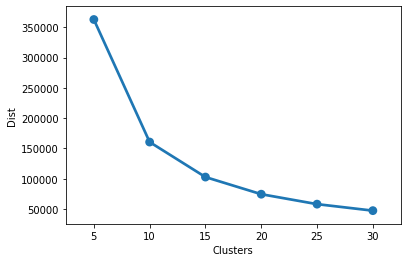

In [9]:
plot_elbow(k_means)

In [10]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 21:40:02: Person - Loading the K_means from cache


In [11]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 21:40:07: Person - Getting the attributes
2019-12-17 21:40:07: Person - Performing one hot encode


In [12]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 21:40:08: Person - Getting the attributes
2019-12-17 21:40:08: Person - Performing one hot encode


In [13]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 21:40:09: Person - Getting the attributes
2019-12-17 21:40:09: Person - Performing one hot encode


Text(0.5, 1.0, 'Online')

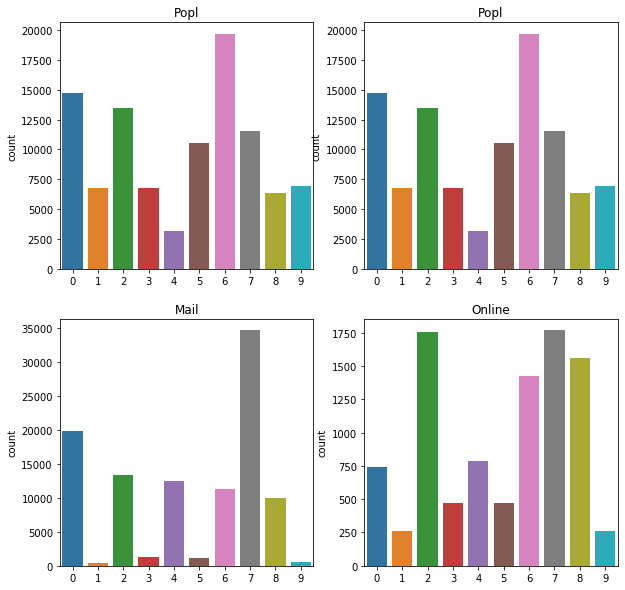

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [ ]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

In [51]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[7, 5]


['NATIONALITAET_KZ_1',
 'SEMIO_ERL_7',
 'GREEN_AVANTGARDE_1.0',
 'FINANZ_VORSORGER_5.0',
 'FINANZ_SPARER_1',
 'SEMIO_RAT_4.0',
 'LP_FAMILIE_GROB_1',
 'FINANZ_MINIMALIST_5',
 'SEMIO_TRADV_2.0',
 'LP_FAMILIE_FEIN_1',
 'ZABEOTYP_3',
 'HEALTH_TYP_2',
 'ZABEOTYP_4',
 'FINANZ_ANLEGER_1',
 'SEMIO_LUST_7',
 'VERS_TYP_1',
 'SEMIO_MAT_7',
 'ANREDE_KZ_1.0',
 'SHOPPER_TYP_1']

In [52]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[8, 7]


['NATIONALITAET_KZ_1',
 'FINANZTYP_6',
 'SEMIO_ERL_7',
 'HEALTH_TYP_3',
 'GREEN_AVANTGARDE_1.0',
 'FINANZ_VORSORGER_5.0',
 'FINANZ_SPARER_1',
 'SEMIO_SOZ_6.0',
 'FINANZ_MINIMALIST_5',
 'SEMIO_KRIT_5',
 'ZABEOTYP_3',
 'SEMIO_TRADV_3.0',
 'SEMIO_KAEM_3',
 'SEMIO_REL_4',
 'FINANZ_ANLEGER_1',
 'SEMIO_LUST_7',
 'SEMIO_ERL_4',
 'ANREDE_KZ_1.0']

**Household**

In [57]:
azdias.loc[:, ['WOHNDAUER_2008', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_ANZ_24',
               'D19_BANKEN_OFFLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
               'D19_VERSAND_ANZ_12', 'HH_EINKOMMEN_SCORE',
               'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_DATUM',
               'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_DATUM',
               'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ANZ_24', 'D19_KONSUMTYP',
               'D19_VERSAND_DATUM', 'D19_VERSI_ANZ_12', 'D19_GESAMT_ONLINE_QUOTE_12',
               'D19_TELKO_OFFLINE_DATUM', 'D19_BANKEN_ANZ_12',
               'D19_GESAMT_ONLINE_DATUM', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_DATUM',
               'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
               'D19_TELKO_DATUM', 'ALTER_HH', 'D19_VERSAND_ONLINE_QUOTE_12',
               'W_KEIT_KIND_HH', 'D19_BANKEN_ANZ_24', 'D19_GESAMT_ANZ_24',
               'D19_VERSI_OFFLINE_DATUM']].isnull().sum()

WOHNDAUER_2008                 0
D19_TELKO_ONLINE_DATUM         0
D19_VERSI_ANZ_24               0
D19_BANKEN_OFFLINE_DATUM       0
D19_TELKO_ANZ_12               0
D19_TELKO_ANZ_24               0
D19_VERSAND_ANZ_12             0
HH_EINKOMMEN_SCORE             0
D19_BANKEN_ONLINE_QUOTE_12     0
D19_BANKEN_DATUM               0
D19_BANKEN_ONLINE_DATUM        0
D19_GESAMT_ANZ_12              0
D19_GESAMT_DATUM               0
D19_VERSAND_ONLINE_DATUM       0
D19_VERSAND_ANZ_24             0
D19_KONSUMTYP                  0
D19_VERSAND_DATUM              0
D19_VERSI_ANZ_12               0
D19_GESAMT_ONLINE_QUOTE_12     0
D19_TELKO_OFFLINE_DATUM        0
D19_BANKEN_ANZ_12              0
D19_GESAMT_ONLINE_DATUM        0
D19_VERSI_DATUM                0
D19_VERSI_ONLINE_DATUM         0
D19_GESAMT_OFFLINE_DATUM       0
D19_VERSAND_OFFLINE_DATUM      0
D19_TELKO_DATUM                0
ALTER_HH                       0
D19_VERSAND_ONLINE_QUOTE_12    0
W_KEIT_KIND_HH                 0
D19_BANKEN

In [71]:
info_level = 'Household'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE)

2019-12-17 22:31:50: Household - Getting the attributes
Index(['WOHNDAUER_2008', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_ANZ_24',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_VERSAND_ANZ_12', 'HH_EINKOMMEN_SCORE',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ANZ_24', 'D19_KONSUMTYP',
       'D19_VERSAND_DATUM', 'D19_VERSI_ANZ_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_TELKO_OFFLINE_DATUM', 'D19_BANKEN_ANZ_12',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_TELKO_DATUM', 'ALTER_HH',
       'D19_VERSAND_ONLINE_QUOTE_12', 'W_KEIT_KIND_HH', 'D19_BANKEN_ANZ_24',
       'D19_GESAMT_ANZ_24'],
      dtype='object')
2019-12-17 22:31:50: Household - Performing one hot encode
> <ipython-input-58-7cf6621073d6>(23)perform_segmentation()
-> enc.fit(X.loc[:, one_hot_enco

(Pdb)  c


2019-12-17 22:31:55: Household - Fitting the scaler
2019-12-17 22:31:55: Household - Running the pca
PCA completed in 0.16 min.
2019-12-17 22:32:05: Household - Running the K_means 
K_means completed in 2.22 min.


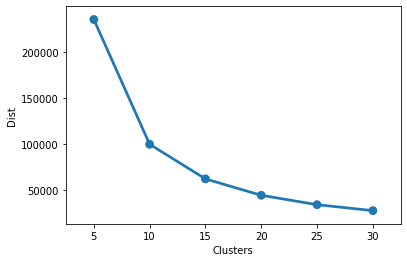

In [72]:
plot_elbow(k_means)

In [73]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 22:34:52: Household - Getting the attributes
2019-12-17 22:34:52: Household - Performing one hot encode
2019-12-17 22:34:52: Household - Transform using the scaler
2019-12-17 22:34:53: Household - Transform using the pca
2019-12-17 22:34:53: Household - Running the K_means 
K_means completed in 0.19 min.


In [74]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 22:35:08: Household - Getting the attributes
2019-12-17 22:35:08: Household - Performing one hot encode


In [75]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 22:35:11: Household - Getting the attributes
2019-12-17 22:35:11: Household - Performing one hot encode


In [76]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 22:35:12: Household - Getting the attributes
2019-12-17 22:35:12: Household - Performing one hot encode


Text(0.5, 1.0, 'Online')

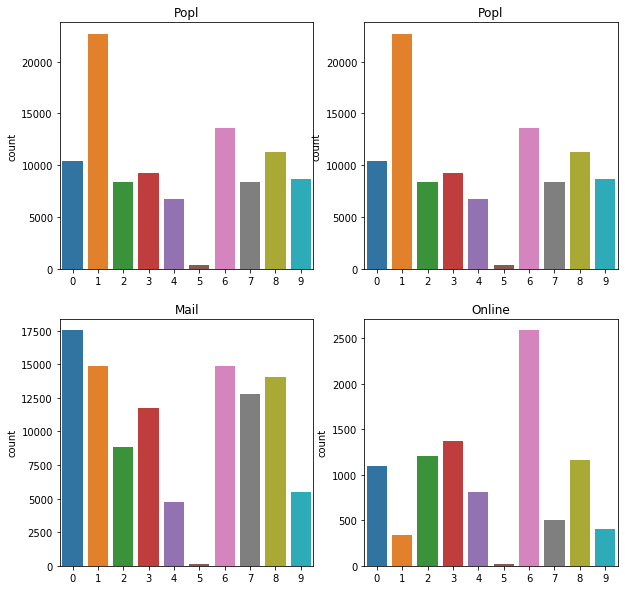

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [104]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

In [105]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[1, 0]


['D19_VERSAND_ONLINE_QUOTE_12_0.0',
 'ANZ_PERSONEN',
 'D19_BANKEN_ANZ_12_0',
 'D19_TELKO_ONLINE_DATUM_10',
 'D19_BANKEN_ONLINE_QUOTE_12_0.0',
 'D19_TELKO_ANZ_12_0',
 'D19_GESAMT_ONLINE_QUOTE_12_0.0',
 'D19_VERSAND_ONLINE_DATUM_10',
 'D19_BANKEN_OFFLINE_DATUM_10',
 'D19_BANKEN_ANZ_24_0',
 'D19_VERSAND_OFFLINE_DATUM_10',
 'D19_TELKO_OFFLINE_DATUM_10',
 'D19_VERSAND_ANZ_12_0']

In [106]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[1, 6]


['D19_VERSAND_ONLINE_QUOTE_12_0.0',
 'ANZ_PERSONEN',
 'D19_VERSAND_ONLINE_QUOTE_12_10.0',
 'D19_BANKEN_ANZ_12_0',
 'D19_TELKO_ONLINE_DATUM_10',
 'D19_TELKO_ANZ_24_0',
 'D19_BANKEN_ONLINE_QUOTE_12_0.0',
 'D19_TELKO_ANZ_12_0',
 'D19_GESAMT_ONLINE_QUOTE_12_0.0',
 'D19_VERSAND_ONLINE_DATUM_10',
 'D19_BANKEN_OFFLINE_DATUM_10',
 'D19_BANKEN_ANZ_24_0',
 'D19_VERSAND_OFFLINE_DATUM_10',
 'D19_TELKO_OFFLINE_DATUM_10',
 'D19_VERSAND_ANZ_12_0']

**Building**

In [119]:
meta_data.loc[meta_data.Attribute == 'OST_WEST_KZ', :] = meta_data.loc[meta_data.Attribute == 'OST_WEST_KZ', :].replace({'O': 0, 'W': 1})

In [160]:
info_level = 'Building'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE=False)

2019-12-17 23:40:21: Building - Getting the attributes
2019-12-17 23:40:21: Building - Performing one hot encode
2019-12-17 23:40:22: Building - Fitting the scaler
Cols to scale {'ANZ_HH_TITEL', 'ANZ_HAUSHALTE_AKTIV'}
2019-12-17 23:40:22: Building - Running the pca
PCA completed in 0.03 min.
2019-12-17 23:40:23: Building - Running the K_means 
K_means completed in 0.90 min.


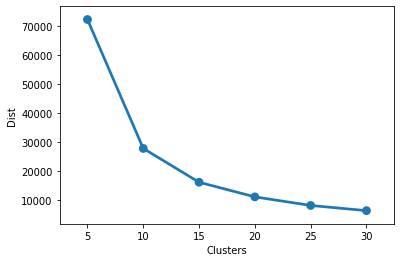

In [161]:
plot_elbow(k_means)

In [162]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 23:41:20: Building - Loading the K_means from cache


In [163]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:41:21: Building - Getting the attributes
2019-12-17 23:41:21: Building - Performing one hot encode


In [164]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:41:22: Building - Getting the attributes
2019-12-17 23:41:22: Building - Performing one hot encode


In [165]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:41:22: Building - Getting the attributes
2019-12-17 23:41:22: Building - Performing one hot encode


Text(0.5, 1.0, 'Online')

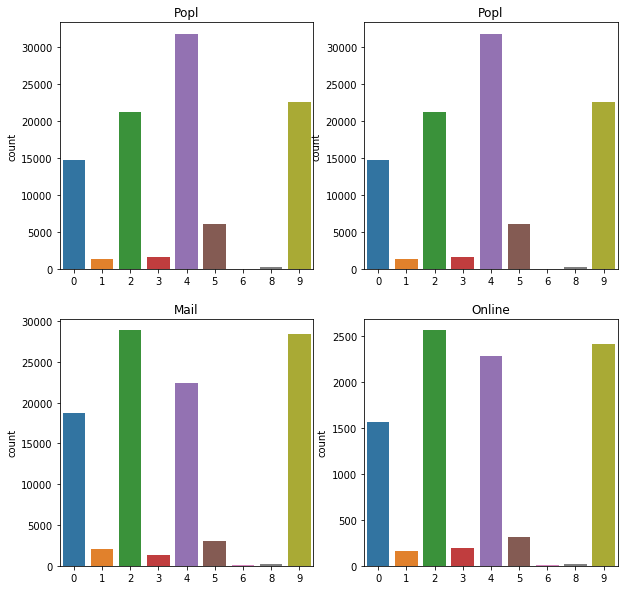

In [166]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [167]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

['ANZ_HH_TITEL', 'ANZ_HAUSHALTE_AKTIV']


In [168]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[4, 2]


['KONSUMNAEHE_3.0',
 'KBA05_HERSTTEMP_1.0',
 'OST_WEST_KZ_1.0',
 'WOHNLAGE_3.0',
 'ANZ_HAUSHALTE_AKTIV',
 'KBA05_MODTEMP_4.0',
 'KBA05_HERSTTEMP_3.0',
 'KBA05_HERSTTEMP_2.0',
 'KBA05_MODTEMP_3.0',
 'GEBAEUDETYP_1.0',
 'KONSUMNAEHE_1.0',
 'GEBAEUDETYP_3.0',
 'OST_WEST_KZ_0.0',
 'GEBAEUDETYP_8.0',
 'KONSUMNAEHE_5.0']

In [169]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[4, 2]


['KONSUMNAEHE_3.0',
 'KBA05_HERSTTEMP_1.0',
 'OST_WEST_KZ_1.0',
 'WOHNLAGE_3.0',
 'ANZ_HAUSHALTE_AKTIV',
 'KBA05_MODTEMP_4.0',
 'KBA05_HERSTTEMP_3.0',
 'KBA05_HERSTTEMP_2.0',
 'KBA05_MODTEMP_3.0',
 'GEBAEUDETYP_1.0',
 'KONSUMNAEHE_1.0',
 'GEBAEUDETYP_3.0',
 'OST_WEST_KZ_0.0',
 'GEBAEUDETYP_8.0',
 'KONSUMNAEHE_5.0']

**Microcell (RR4_ID)**

In [170]:
info_level = 'Microcell (RR4_ID)'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE)

2019-12-17 23:41:56: Microcell (RR4_ID) - Getting the attributes
2019-12-17 23:41:56: Microcell (RR4_ID) - Loading the enc from cache
2019-12-17 23:41:56: Microcell (RR4_ID) - Loading the pca from cache
2019-12-17 23:41:57: Microcell (RR4_ID) - Loading the K_means from cache


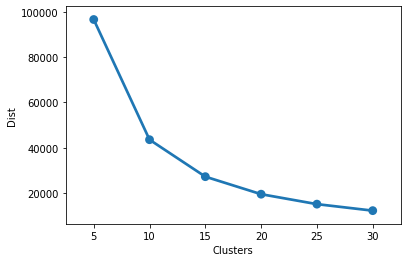

In [171]:
plot_elbow(k_means)

In [175]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 23:42:57: Microcell (RR4_ID) - Getting the attributes
2019-12-17 23:42:57: Microcell (RR4_ID) - Performing one hot encode
2019-12-17 23:42:57: Microcell (RR4_ID) - Transform using the pca
2019-12-17 23:42:57: Microcell (RR4_ID) - Running the K_means 
K_means completed in 0.14 min.


In [176]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:43:10: Microcell (RR4_ID) - Getting the attributes
2019-12-17 23:43:10: Microcell (RR4_ID) - Performing one hot encode


In [177]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:43:11: Microcell (RR4_ID) - Getting the attributes
2019-12-17 23:43:11: Microcell (RR4_ID) - Performing one hot encode


In [178]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:43:12: Microcell (RR4_ID) - Getting the attributes
2019-12-17 23:43:12: Microcell (RR4_ID) - Performing one hot encode


Text(0.5, 1.0, 'Online')

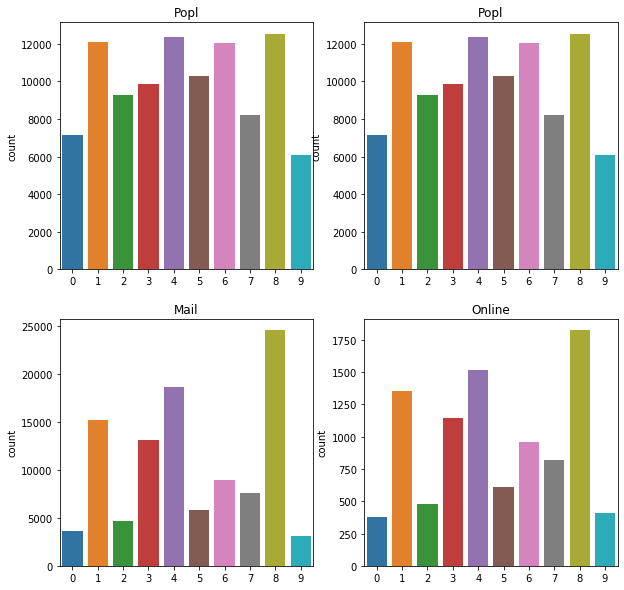

In [179]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [180]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    print(scale_cols)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

In [181]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[8, 4]


['KBA05_ALTER4_3.0',
 'KBA05_ANHANG_1.0',
 'KBA05_ALTER2_2.0',
 'KBA05_ALTER3_3.0',
 'KBA05_ANTG1_4.0',
 'KBA05_ALTER4_4.0',
 'KBA05_ANTG2_0.0',
 'KBA05_ANTG4_0.0',
 'KBA05_ALTER1_1.0',
 'KBA05_ALTER1_2.0',
 'KBA05_ANTG1_3.0',
 'KBA05_ALTER2_3.0',
 'KBA05_ANTG2_1.0',
 'KBA05_ANTG3_0.0']

In [182]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[8, 2]


['KBA05_ALTER4_3.0',
 'KBA05_ANHANG_1.0',
 'KBA05_ALTER2_2.0',
 'KBA05_ALTER3_3.0',
 'KBA05_ANHANG_0.0',
 'KBA05_ALTER4_4.0',
 'KBA05_ANTG1_0.0',
 'KBA05_ANTG2_0.0',
 'KBA05_ANTG3_3.0',
 'KBA05_ANTG4_0.0',
 'KBA05_ALTER1_1.0',
 'KBA05_ANTG1_3.0',
 'CAMEO_DEUG_2015_8.0',
 'KBA05_ALTER2_3.0',
 'KBA05_ANTG2_1.0',
 'KBA05_ANTG3_0.0']

**Microcell (RR3_ID)**

In [183]:
info_level = 'Microcell (RR3_ID)'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE)

2019-12-17 23:43:31: Microcell (RR3_ID) - Getting the attributes
2019-12-17 23:43:31: Microcell (RR3_ID) - Loading the enc from cache
2019-12-17 23:43:32: Microcell (RR3_ID) - Loading the pca from cache
2019-12-17 23:43:36: Microcell (RR3_ID) - Loading the K_means from cache


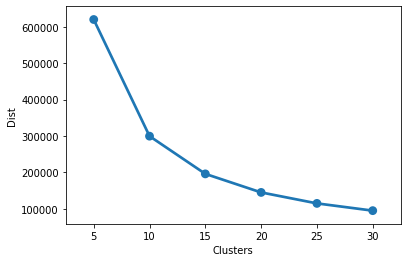

In [184]:
plot_elbow(k_means)

In [185]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 23:43:37: Microcell (RR3_ID) - Loading the K_means from cache


In [186]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:43:37: Microcell (RR3_ID) - Getting the attributes
2019-12-17 23:43:37: Microcell (RR3_ID) - Performing one hot encode


In [187]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:43:38: Microcell (RR3_ID) - Getting the attributes
2019-12-17 23:43:38: Microcell (RR3_ID) - Performing one hot encode


In [188]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:43:39: Microcell (RR3_ID) - Getting the attributes
2019-12-17 23:43:39: Microcell (RR3_ID) - Performing one hot encode


Text(0.5, 1.0, 'Online')

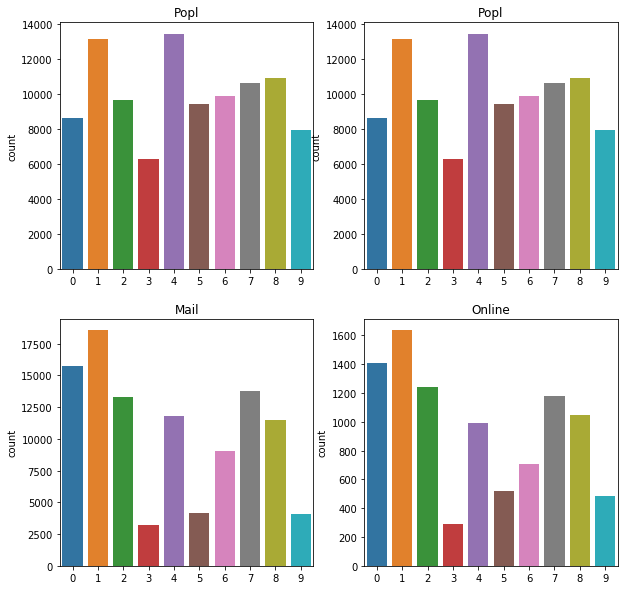

In [189]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [190]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    print(scale_cols)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

In [191]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[0, 5]


['KBA05_CCM1_2.0',
 'KBA05_SEG9_2.0',
 'KBA05_MAXVORB_4.0',
 'KBA05_MOD8_2.0',
 'KBA05_MOD8_0.0',
 'KBA05_SEG9_0.0',
 'KBA05_SEG1_1.0',
 'KBA05_KRSVAN_2.0',
 'KBA05_VORB1_3.0',
 'KBA05_SEG1_2.0',
 'KBA05_KRSHERST3_1.0',
 'KBA05_KRSHERST2_2.0',
 'KBA05_KRSHERST2_3.0',
 'KBA05_MAXBJ_1.0',
 'KBA05_SEG7_1.0',
 'KBA05_SEG8_0.0',
 'KBA05_ZUL2_3.0']

In [192]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[0, 1]


['KBA05_CCM1_2.0',
 'KBA05_SEG9_2.0',
 'KBA05_MOTOR_3.0',
 'KBA05_SEG7_2.0',
 'KBA05_MOD8_2.0',
 'KBA05_HERST3_3.0',
 'KBA05_KRSVAN_2.0',
 'KBA05_CCM1_3.0',
 'KBA05_VORB1_3.0',
 'KBA05_KRSOBER_2.0',
 'KBA05_SEG1_2.0',
 'KBA05_HERST5_3.0',
 'KBA05_MAXSEG_2.0',
 'KBA05_KRSHERST3_1.0',
 'KBA05_KRSHERST2_2.0',
 'KBA05_SEG7_1.0',
 'KBA05_KRSHERST1_3.0',
 'KBA05_ZUL2_3.0']

**125m x 125m Grid**

Nothing to analyse here

**Postcode**

Nothing to analyse here

**RR1_ID**

In [193]:
info_level = 'RR1_ID'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE)

2019-12-17 23:44:08: RR1_ID - Getting the attributes
2019-12-17 23:44:08: RR1_ID - Loading the enc from cache
2019-12-17 23:44:08: RR1_ID - Loading the pca from cache
2019-12-17 23:44:08: RR1_ID - Loading the K_means from cache


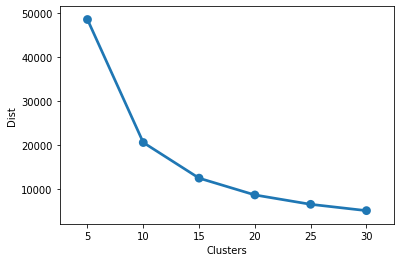

In [194]:
plot_elbow(k_means)

In [195]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 23:44:09: RR1_ID - Loading the K_means from cache


In [196]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:44:09: RR1_ID - Getting the attributes
2019-12-17 23:44:09: RR1_ID - Performing one hot encode


In [197]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:44:10: RR1_ID - Getting the attributes
2019-12-17 23:44:10: RR1_ID - Performing one hot encode


In [198]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:44:10: RR1_ID - Getting the attributes
2019-12-17 23:44:10: RR1_ID - Performing one hot encode


Text(0.5, 1.0, 'Online')

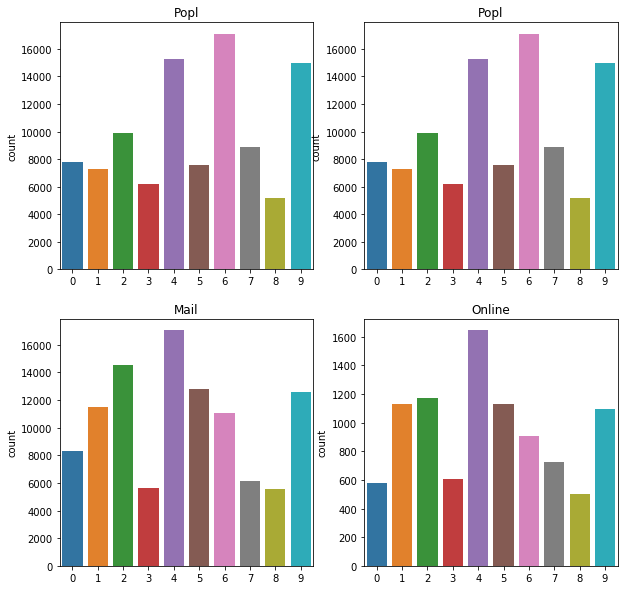

In [199]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [200]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    print(scale_cols)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

In [201]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[6, 5]


['KKK_4.0',
 'ONLINE_AFFINITAET_5.0',
 'KKK_1.0',
 'MOBI_REGIO_4.0',
 'REGIOTYP_3.0',
 'MOBI_REGIO_1.0',
 'REGIOTYP_2.0',
 'REGIOTYP_5.0',
 'MOBI_REGIO_3.0',
 'KKK_2.0',
 'KKK_3.0',
 'ONLINE_AFFINITAET_2.0',
 'ONLINE_AFFINITAET_3.0',
 'MOBI_REGIO_5.0',
 'ONLINE_AFFINITAET_4.0',
 'GEBAEUDETYP_RASTER_3.0',
 'GEBAEUDETYP_RASTER_4.0']

In [202]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[6, 1]


['KKK_4.0',
 'ONLINE_AFFINITAET_5.0',
 'KKK_1.0',
 'MOBI_REGIO_4.0',
 'MOBI_REGIO_1.0',
 'REGIOTYP_2.0',
 'REGIOTYP_5.0',
 'MOBI_REGIO_3.0',
 'KKK_2.0',
 'ONLINE_AFFINITAET_2.0',
 'ONLINE_AFFINITAET_3.0',
 'MOBI_REGIO_5.0',
 'ONLINE_AFFINITAET_4.0',
 'GEBAEUDETYP_RASTER_3.0',
 'GEBAEUDETYP_RASTER_4.0']

**PLZ8**

In [203]:
info_level = 'PLZ8'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE)

2019-12-17 23:44:12: PLZ8 - Getting the attributes
2019-12-17 23:44:12: PLZ8 - Loading the enc from cache
2019-12-17 23:44:15: PLZ8 - Loading the scaler from cache
2019-12-17 23:44:15: PLZ8 - Loading the pca from cache
2019-12-17 23:44:31: PLZ8 - Loading the K_means from cache


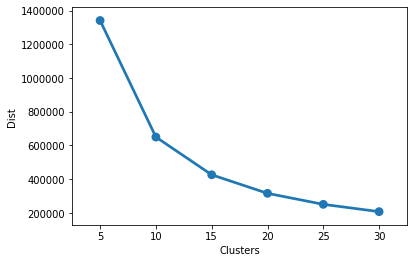

In [204]:
plot_elbow(k_means)

In [205]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 23:44:32: PLZ8 - Loading the K_means from cache


In [206]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:44:32: PLZ8 - Getting the attributes
2019-12-17 23:44:32: PLZ8 - Performing one hot encode


In [207]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:44:37: PLZ8 - Getting the attributes
2019-12-17 23:44:37: PLZ8 - Performing one hot encode


In [208]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:44:42: PLZ8 - Getting the attributes
2019-12-17 23:44:42: PLZ8 - Performing one hot encode


Text(0.5, 1.0, 'Online')

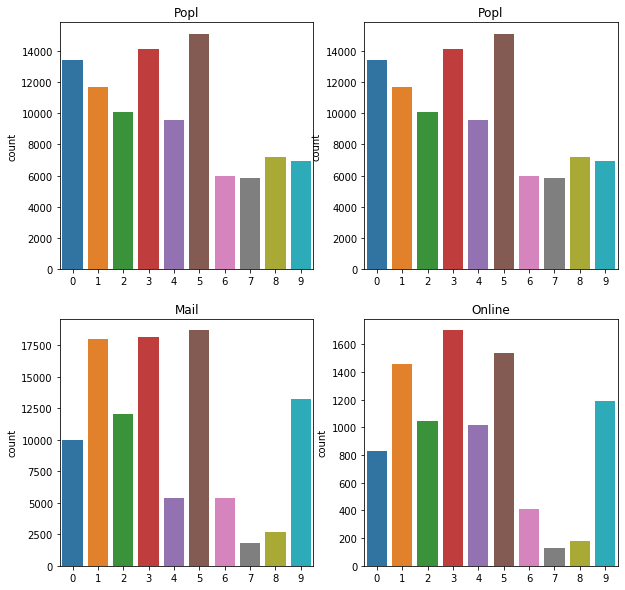

In [209]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [210]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    print(scale_cols)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

['KBA13_ANZAHL_PKW']


In [211]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[9, 1]


['KBA13_KMH_180_1.0',
 'KBA13_KW_50_3.0',
 'KBA13_ALTERHALTER_60_3.0',
 'KBA13_KW_80_2.0',
 'KBA13_SITZE_5_1.0',
 'KBA13_CCM_2500_1.0',
 'KBA13_ALTERHALTER_45_1.0',
 'KBA13_KRSHERST_AUDI_VW_0.0',
 'PLZ8_ANTG4_1.0',
 'KBA13_MERCEDES_5.0',
 'KBA13_PEUGEOT_1.0',
 'KBA13_ANZAHL_PKW',
 'KBA13_KRSAQUOT_2.0',
 'KBA13_HALTER_66_2.0']

In [212]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[9, 8]


['KBA13_CCM_0_1400_4.0',
 'KBA13_KW_50_3.0',
 'KBA13_KW_80_2.0',
 'KBA13_SITZE_5_1.0',
 'KBA13_ALTERHALTER_45_1.0',
 'KBA13_HALTER_35_3.0',
 'KBA13_KRSHERST_AUDI_VW_0.0',
 'PLZ8_ANTG4_1.0',
 'KBA13_MERCEDES_5.0',
 'KBA13_FAB_SONSTIGE_2.0',
 'KBA13_PEUGEOT_1.0',
 'KBA13_ANZAHL_PKW',
 'KBA13_KRSAQUOT_2.0',
 'KBA13_HALTER_66_2.0']

**Community**

In [222]:
info_level = 'Community'
enc, scaler, pca, k_means = perform_segmentation(azdias, meta_data, info_level, non_categorical, pca_var, USE_MODEL_CACHE)

2019-12-17 23:52:55: Community - Getting the attributes
2019-12-17 23:52:55: Community - Performing one hot encode
Cols to scale set()
2019-12-17 23:52:55: Community - Running the pca
PCA completed in 0.01 min.
2019-12-17 23:52:56: Community - Running the K_means 
K_means completed in 0.39 min.


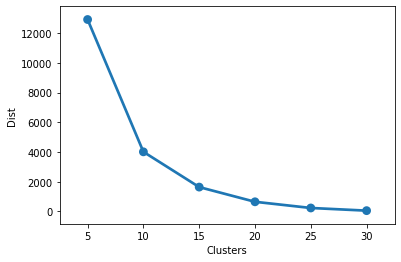

In [223]:
plot_elbow(k_means)

In [225]:
k_mean_final = fit_k_means_final(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, 10, USE_MODEL_CACHE)

2019-12-17 23:53:42: Community - Getting the attributes
2019-12-17 23:53:42: Community - Performing one hot encode
2019-12-17 23:53:42: Community - Transform using the pca
2019-12-17 23:53:42: Community - Running the K_means 
K_means completed in 0.05 min.


In [226]:
popl_k_means = predict_pca_kmeans(azdias, meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:53:49: Community - Getting the attributes
2019-12-17 23:53:49: Community - Performing one hot encode


In [227]:
mail_customers_k_means = predict_pca_kmeans(customer.loc[mail_order_customers, :].dropna(how='any'), 
                                            meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:53:50: Community - Getting the attributes
2019-12-17 23:53:50: Community - Performing one hot encode


In [228]:
online_customers_k_means = predict_pca_kmeans(customer.loc[online_order_customers, :].dropna(how='any'), 
                                              meta_data, info_level, non_categorical, enc, scaler, pca, k_mean_final)

2019-12-17 23:53:50: Community - Getting the attributes
2019-12-17 23:53:50: Community - Performing one hot encode


Text(0.5, 1.0, 'Online')

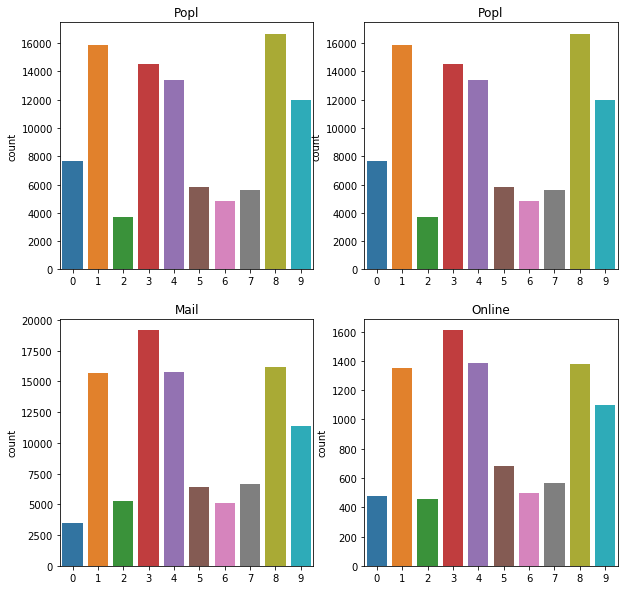

In [229]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(popl_k_means, ax=ax[0, 0]).set_title('Popl')
sns.countplot(mail_customers_k_means, ax=ax[1, 0]).set_title('Mail')
sns.countplot(popl_k_means, ax=ax[0, 1]).set_title('Popl')
sns.countplot(online_customers_k_means, ax=ax[1, 1]).set_title('Online')

In [230]:
centroid_kmeaninv = pca.inverse_transform(k_mean_final.cluster_centers_)
if scaler:
    scale_cols = get_scaler_col_names(azdias.columns, info_level, meta_data, non_categorical)
    print(scale_cols)
    centroid_kmeaninv[:, 0:len(scaler_cols)] = scaler.inverse_transform(centroid_kmeaninv[:, 0:len(scaler_cols)])
else:
    scale_cols = []

enc_col_names = get_encoded_col_names(azdias.columns, info_level, meta_data, non_categorical, enc)

centroid_inv = pd.DataFrame(centroid_kmeaninv, columns=scale_cols + enc_col_names)
centroid_inv.index.name = 'Cluster'

In [231]:
chosen_clusters = choose_cluster(popl_k_means, mail_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[0, 3]


['RELAT_AB_3.0',
 'RELAT_AB_4.0',
 'ORTSGR_KLS9_5.0',
 'RELAT_AB_5.0',
 'RELAT_AB_1.0',
 'ORTSGR_KLS9_2.0',
 'RELAT_AB_2.0',
 'ORTSGR_KLS9_6.0',
 'ORTSGR_KLS9_3.0',
 'ORTSGR_KLS9_1.0',
 'ORTSGR_KLS9_4.0',
 'ORTSGR_KLS9_9.0']

In [232]:
chosen_clusters = choose_cluster(popl_k_means, online_customers_k_means, n=2)
print(chosen_clusters)
attributes_list = []
for cl in chosen_clusters:
    attr = view_centroid_info(centroid_inv, cluster=cl, n=10).Attribute
    attributes_list = list(set(attributes_list).union(set(attr)))

attributes_list

[0, 3]


['RELAT_AB_3.0',
 'RELAT_AB_4.0',
 'ORTSGR_KLS9_5.0',
 'RELAT_AB_5.0',
 'RELAT_AB_1.0',
 'ORTSGR_KLS9_2.0',
 'RELAT_AB_2.0',
 'ORTSGR_KLS9_6.0',
 'ORTSGR_KLS9_3.0',
 'ORTSGR_KLS9_1.0',
 'ORTSGR_KLS9_4.0',
 'ORTSGR_KLS9_9.0']

## Summary of Part 1

After performing the K-Means clustering for each of the Information Level,  here are the conclusions
1. `Person` - offers the greatest amount of information to help with the decision betwen Popl-Customer and Mail-Online
1. The following Information level can only help to identify customer , but not segregate the Popl-Mail
* `Household`
* `Microcell (RR4_ID)`
* `Microcell (RR3_ID)`
* `RR1_ID`
* `PLZ8`
1. `Building`, `Community` offer no information

WE shall try using only `Person` information level first. If the results are not acceptable, we can build a two tier model,  

using the 5 information level to first identify the customer and then apply the `Person` attibutes to further narrow down on potential clients.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [157]:
mailout_train = read_data('data/Udacity_MAILOUT_052018_TRAIN.csv', meta_data)
y = mailout_train.RESPONSE

no_meta_cols = set(mailout_train.columns) - set(meta_data.Attribute)
mailout_train.drop(no_meta_cols, axis=1, inplace=True)

mailout_train['RESPONSE'] = y

mailout_train.shape

(42962, 264)

### Subset to only PERSON Attributes from K-Means filtering.

In [158]:
# person_attrb = meta_data.loc[meta_data.loc[:, 'Information level']=='Person', 'Attribute'].unique().tolist()
# person_attrb = set(mailout_train.columns).intersection(set(person_attrb))

person_attrb = ['NATIONALITAET_KZ',
                'SEMIO_ERL',
                'GREEN_AVANTGARDE',
                'FINANZ_VORSORGER',
                'FINANZ_SPARER',
                'SEMIO_RAT',
                'LP_FAMILIE_GROB',
                'FINANZ_MINIMALIST',
                'SEMIO_TRADV',
                'LP_FAMILIE_FEIN',
                'ZABEOTYP',
                'HEALTH_TYP',
                'FINANZ_ANLEGER',
                'SEMIO_LUST',
                'VERS_TYP',
                'SEMIO_MAT',
                'ANREDE_KZ',
                'SHOPPER_TYP',
                'FINANZTYP',
                'SEMIO_SOZ',
                'SEMIO_KRIT',
                'SEMIO_KAEM',
                'SEMIO_REL',
                ]

X = mailout_train.loc[:, [*person_attrb, 'RESPONSE']]
print('X shape', X.shape)

X shape (42962, 24)


In [159]:
# If we look at only complete cases we may loose upto 20% of data
print(X.dropna(how='any', axis=0).RESPONSE.value_counts())
X.dropna(how='any', axis=0).shape

0    34543
1      438
Name: RESPONSE, dtype: int64


(34981, 24)

In [160]:
imp = SimpleImputer(strategy='median')
imp.fit(X.loc[:, person_attrb])
X.loc[:, person_attrb] = pd.DataFrame(imp.transform(X.loc[:, person_attrb]), index=X.index, columns=person_attrb)

In [161]:
y = X.RESPONSE
X = X.loc[:, person_attrb]

In [162]:
#  get_dummies vs OneHotEncoder - https://stackoverflow.com/a/56567037/6931113
non_categorical = ['ANZ_HAUSHALTE_AKTIV',
                   'ANZ_HH_TITEL',
                   'ANZ_PERSONEN',
                   'ANZ_TITEL',
                   'KBA13_ANZAHL_PKW',
                  ]

# All out data is categorical - so only use the one hot encoder.
enc_categories = [list(meta_data.loc[(meta_data.Attribute == attrb) & (meta_data.Meaning != 'unknown'), 'Value'].astype(
            float).sort_values()) for attrb in person_attrb]

enc = OneHotEncoder(categories=enc_categories, handle_unknown='ignore')
enc.fit(X.loc[:, person_attrb])

OneHotEncoder(categorical_features=None,
              categories=[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
                          [0.0, 1.0], [1.0, 2.0, 3.0, 4.0, 5.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                           11.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                           11.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0, 6...
                          [1.0, 2.0, 3.0, 4.0, 5.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], [1.0, 2.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], [1.0, 2.0],
                          [0.0, 1.0, 2.0, 3.0], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
                  

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, make_scorer

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [165]:
rnd_clsf = RandomForestClassifier(n_estimators=100)
kf = KFold(n_splits=5, shuffle=True)

In [166]:
start_time = time.perf_counter()
param_grid = {'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 4],
               'min_samples_leaf': [1, 2]             
             }
roc_scorer = make_scorer(roc_auc_score, average='macro')
g_clf = GridSearchCV(rnd_clsf, cv=kf, param_grid=param_grid, n_jobs=4, scoring=roc_scorer)

g_clf.fit(enc.transform(X_train), y_train)

print('Model fit in {:.2f} min'.format((time.perf_counter() - start_time)/60))

Model fit in 2.93 min


In [169]:
print("Best parameters set found on development set:")
print()
print(g_clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = g_clf.cv_results_['mean_test_score']
stds = g_clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, g_clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, g_clf.predict(enc.transform(X_test))
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}

Grid scores on development set:

0.500 (+/-0.000) for {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.500 (+/-0.000) for {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 4}
0.500 (+/-0.000) for {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2}
0.500 (+/-0.000) for {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 4}
0.501 (+/-0.004) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.500 (+/-0.000) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 4}
0.500 (+/-0.000) for {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2}
0.500 (+/-0.000) for {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 4}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the 

In [154]:
from joblib import dump, load
dump(g_clf, 'data/model/grid_search_clf_kf.joblib') 

['data/model/grid_search_clf_kf.joblib']

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [170]:
mailout_test = read_data('data/Udacity_MAILOUT_052018_TEST.csv', meta_data)

no_meta_cols = set(mailout_test.columns) - set(meta_data.Attribute)
mailout_test.drop(no_meta_cols, axis=1, inplace=True)

mailout_test.shape

(42833, 263)

In [171]:
# person_attrb = meta_data.loc[meta_data.loc[:, 'Information level']=='Person', 'Attribute'].unique().tolist()
# person_attrb = set(mailout_train.columns).intersection(set(person_attrb))

person_attrb = ['NATIONALITAET_KZ',
                'SEMIO_ERL',
                'GREEN_AVANTGARDE',
                'FINANZ_VORSORGER',
                'FINANZ_SPARER',
                'SEMIO_RAT',
                'LP_FAMILIE_GROB',
                'FINANZ_MINIMALIST',
                'SEMIO_TRADV',
                'LP_FAMILIE_FEIN',
                'ZABEOTYP',
                'HEALTH_TYP',
                'FINANZ_ANLEGER',
                'SEMIO_LUST',
                'VERS_TYP',
                'SEMIO_MAT',
                'ANREDE_KZ',
                'SHOPPER_TYP',
                'FINANZTYP',
                'SEMIO_SOZ',
                'SEMIO_KRIT',
                'SEMIO_KAEM',
                'SEMIO_REL',
                ]

X = mailout_test.loc[:, person_attrb]
X.shape

(42833, 23)

In [172]:
imp = SimpleImputer(strategy='median')
imp.fit(X.loc[:, person_attrb])
X.loc[:, person_attrb] = pd.DataFrame(imp.transform(X.loc[:, person_attrb]), index=X.index, columns=person_attrb)

In [173]:
X = X.loc[:, person_attrb]

In [ ]:
non_categorical = ['ANZ_HAUSHALTE_AKTIV',
                   'ANZ_HH_TITEL',
                   'ANZ_PERSONEN',
                   'ANZ_TITEL',
                   'KBA13_ANZAHL_PKW',
                  ]

# All out data is categorical - so only use the one hot encoder.
enc_categories = [list(meta_data.loc[(meta_data.Attribute == attrb) & (meta_data.Meaning != 'unknown'), 'Value'].astype(
            float).sort_values()) for attrb in person_attrb]

enc = OneHotEncoder(categories=enc_categories, handle_unknown='ignore')
enc.fit(X.loc[:, person_attrb])

In [174]:
g_clf = load('data/model/grid_search_clf_kf.joblib') 

In [177]:
y_test = g_clf.predict(enc.transform(X))

In [182]:
pd.DataFrame({'RESPONSE': y_test}, index = X.index).to_csv('predictions.csv')

In [183]:
azdias.columns

Index(['ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015',
       'CJT_GESAMTTYP',
       ...
       'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=272)

In [184]:
col_names = azdias.columns
col_names = [c.replace('_', ' ') for c in col_names]
# Initialise the translator
from googletrans import Translator
translator = Translator()


col_names_en = [translator.translate(c, src="de", dest="en").text for c in col_names]
# Put back the _
col_names_en = [c.replace(' ', '_') for c in col_names_en]
# View as data frame
new_cols = pd.DataFrame({'Original': col_names, 'Translation': col_names_en})

In [185]:
new_cols

,Original,Translation
0,ALTER HH,ALTER_HH
1,ANZ HAUSHALTE AKTIV,ANZ_HOUSEHOLDS_ACTIVE
2,ANZ HH TITEL,ANZ_HH_TITLE
3,ANZ PERSONEN,ANZ_PEOPLE
4,ANZ TITEL,ANZ_TITLE
...,...,...
267,WOHNDAUER 2008,RESIDENTIAL_DURATION_2008
268,WOHNLAGE,RESIDENTIAL_MANAGEMENT
269,ZABEOTYP,ZABEOTYP
270,ANREDE KZ,TITLE_KZ
